# 1. Data preprocessing

## 1.1 File Consolidation

In [2]:
import os
import re
import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import copy

from pathlib import Path
from dataclasses import dataclass
from typing import List
from statsmodels.tsa.stattools import adfuller
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score
)


In [16]:
# Target companies, keep company names in Chinese as requested
companies = ["万科A", "比亚迪", "中国石油", "贵州茅台", "中国石化"]

# Locate all yearly files
BASE_DIR = Path(os.environ.get("DATA_DIR", Path.home())).expanduser().resolve()
DATA_DIR = (BASE_DIR /"Desktop").resolve()
pattern = str(DATA_DIR /"Thesis"/"news data"/"网络新闻量化统计（按自然日）-*.xlsx")

files = sorted(glob.glob(pattern))
if not files:
    raise FileNotFoundError(f"No files matched pattern: {pattern}")

def extract_year(path: str):
    m = re.search(r"-(\d{4})\.xlsx$", os.path.basename(path))
    return int(m.group(1)) if m else None

# file columns
usecols = [
    "Scode", "Coname", "Date",
    "Newsnum_Title", "Newsnum_Cont",
    "Posnews_All", "Neunews_All", "Negnews_All",
    "Posnews_Ori", "Neunews_Ori", "Negnews_Ori"
]

# Read, clean, filter, and merge across files
dfs = []
for fp in files:
    df = pd.read_excel(fp, usecols=usecols, dtype={"Scode": str})

    # Drop the first "Chinese description/header" row 
    df = df[df["Coname"].notna()]
    df = df[(df["Coname"] != "公司简称") & (df["Scode"] != "股票代码")]

    # Parse date as datetime
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df[df["Date"].notna()]

    # Filter target companies
    df = df[df["Coname"].isin(companies)].copy()

    # Add year and source filename
    df["Year"] = extract_year(fp)
    df["SourceFile"] = os.path.basename(fp)

    dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True)
all_df = all_df.sort_values(["Coname", "Date"]).reset_index(drop=True)

# Output file
out_path = str(DATA_DIR / "news_data.xlsx")

with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
    all_df.to_excel(writer, index=False, sheet_name="long")

    pivot = all_df.pivot_table(
        index="Date",
        columns="Coname",
        values=[
            "Newsnum_Title", "Newsnum_Cont",
            "Posnews_All", "Neunews_All", "Negnews_All",
            "Posnews_Ori", "Neunews_Ori", "Negnews_Ori"
        ],
        aggfunc="sum"
    )
    pivot.to_excel(writer, sheet_name="wide_pivot")

print(f"Merge completed: {out_path}")
print("Total rows:", len(all_df))
print("Years covered:", sorted(all_df["Year"].dropna().unique().tolist()))


Merge completed: /Users/Zhuanz1/Desktop/news_data.xlsx
Total rows: 17679
Years covered: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [21]:
THESIS_DIR = BASE_DIR /"Desktop"/"Thesis"
pattern = str(HESIS_DIR / "*price.xlsx")
files = sorted(glob.glob(pattern))
if not files:
    raise FileNotFoundError(f"No price files found in: {pattern}")

# Target stocks
code_to_name = {
    "000002": "万科A",
    "002594": "比亚迪",
    "601857": "中国石油",
    "600519": "贵州茅台",
    "600028": "中国石化",
}
target_codes = set(code_to_name.keys())

dfs = []
for fp in files:
    df = pd.read_excel(fp, sheet_name=0)

    # Keep only rows that look like real dates
    df["TradingDate"] = pd.to_datetime(df["TradingDate"], errors="coerce")
    df = df[df["TradingDate"].notna()].copy()

    # Standardize code to 6-digit string
    df["Symbol"] = df["Symbol"].astype(str).str.extract(r"(\d{6})", expand=False)

    # Filter target companies
    df = df[df["Symbol"].isin(target_codes)].copy()

    # Add company name and year
    df["Coname"] = df["Symbol"].map(code_to_name)
    df["Year"] = df["TradingDate"].dt.year
    df["SourceFile"] = os.path.basename(fp)

    dfs.append(df)

merged = pd.concat(dfs, ignore_index=True)

# Sort by company + year + date
merged = merged.sort_values(["Coname", "Year", "TradingDate"]).reset_index(drop=True)

# Output
out_path = str(HESIS_DIR / "price_data.xlsx")
merged.to_excel(out_path, index=False)

print("Merged rows:", len(merged))
print("Saved to:", out_path)
print("Companies:", merged["Coname"].unique().tolist())
print("Years:", sorted(merged["Year"].unique().tolist()))


/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/var/folders/8_/b_5nx43j4s9dttgkt926cd740000gp/T/ipykernel_84158/1584366173.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["TradingDate"] = pd.to_datetime(df["TradingDate"], errors="coerce")
/var/folders/8_/b_5nx43j4s9dttgkt926cd740000gp/T/ipykernel_84158/1584366173.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["TradingDate"] = pd.to_datetime(df["TradingDate"], errors="coerce")
/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/openpyxl/styles/stylesheet.py:

Merged rows: 13040
Saved to: /Users/Zhuanz1/Desktop/Thesis/price_data.xlsx
Companies: ['万科A', '中国石化', '中国石油', '比亚迪', '贵州茅台']
Years: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [8]:
# Input files
input_files = [
    THESIS_DIR / "price_data.xlsx",
    THESIS_DIR / "news_data.xlsx",
]

# Chinese -> English mapping
name_map = {
    "万科A": "Vanke A",
    "中国石化": "Sinopec",
    "中国石油": "PetroChina",
    "比亚迪": "BYD",
    "贵州茅台": "Kweichow Moutai",
}

# Possible company-name columns
NAME_COL_CANDIDATES = ["Coname", "name", "公司", "公司简称", "证券简称"]

def find_name_cols(columns):
    return [c for c in NAME_COL_CANDIDATES if c in columns]

for fp in input_files:
    xls = pd.ExcelFile(fp)
    out_path = os.path.splitext(fp)[0] + "_EN.xlsx"

    with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
        for sheet in xls.sheet_names:
            df = pd.read_excel(fp, sheet_name=sheet)

            # Detect name columns in this sheet
            name_cols = find_name_cols(df.columns)

            # Replace in all detected name columns
            for col in name_cols:
                df[col] = df[col].astype(str).replace(name_map)

            df.to_excel(writer, sheet_name=sheet, index=False)

    print(f"Done: {out_path}")


Done: /Users/Zhuanz1/Desktop/Thesis/price_data_EN.xlsx
Done: /Users/Zhuanz1/Desktop/Thesis/news_data_EN.xlsx


In [12]:
import pandas as pd

# File paths
price_path = THESIS_DIR / "price_data_EN.xlsx"
news_path  = THESIS_DIR / "news_data_EN.xlsx"
out_path   = THESIS_DIR / "price_news_merged.xlsx"

# Read files
price = pd.read_excel(price_path)
news  = pd.read_excel(news_path)

# Convert Date to datetime
price["Date"] = pd.to_datetime(price["Date"], errors="coerce")
news["Date"]  = pd.to_datetime(news["Date"], errors="coerce")

# Shift news date forward by 1 day so that news on (t-1) matches price on t
news["Date"] = news["Date"] + pd.Timedelta(days=1)

# Merge
merged = pd.merge(price, news, on=["Scode", "Date"], how="left")

# Sort and save
merged = merged.sort_values(["Scode", "Date"])
merged.to_excel(out_path, index=False)

print("Saved to:", out_path)
print("Merged rows:", len(merged))


Saved to: /Users/Zhuanz1/Desktop/Thesis/price_news_merged.xlsx
Merged rows: 13040


## 1.2 Indicator Calculation

### 1.2.1 Technical Indicators

In [401]:
# Read files
THESIS_DIR = Path(THESIS_DIR).expanduser().resolve()

df = pd.read_excel(THESIS_DIR /"data"/"price_news_merged.xlsx")
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).copy()

df["Scode"] = df["Scode"].astype(str).str.extract(r"(\d{6})", expand=False)
df = df.dropna(subset=["Scode"]).copy()

df = df.sort_values(["Scode", "Date"]).reset_index(drop=True)

# Parameter: (High * Low)^a in PWHLD, a = 0.5 means square root
a = 0.5
# Small constant to avoid division by zero
gamma = 1e-12
# warm-up：每只股票至少需要的历史长度（用于滚动窗口最大为50（PRM））
min_history = 50

def add_factors(g):
    g = g.copy()
    close = g["ClosePrice"]
    open_ = g["OpenPrice"]
    high = g["HighPrice"]
    low = g["LowPrice"]
    vol = g["Volume"]
    amt = g["Amount"]

    # r_t^(1) = ln(P_{t+1}) - ln(P_t)
    g["Return_1d"] = np.log(close.shift(-1)) - np.log(close)
    g["Return_5d"] = np.log(close.shift(-5)) - np.log(close)

    # Binary label (up = 1, down = 0) 
    g["y_up_1d"] = (g["Return_1d"] > 0).astype(int)  # 表示 “从 t 到 t+1 是否上涨(方向)”
    g["y_up_5d"] = (g["Return_5d"] > 0).astype(int)  # t日买入并持有 5 个交易日，到第t+5日的方向（涨/跌）
    
    # VA6DR = ((Close_t - Close_{t-6}) / Close_{t-6}) * Volume_t
    g["VA6DR"] = ((close - close.shift(6)) / (close.shift(6) + gamma)) * vol

    # UMF = (sum_{i=1..20} I(Close_{t-i} > Close_{t-i-1}) / 20) * 100
    up = (close.diff() > 0).astype(float)  
    g["UMF"] = up.shift(1).rolling(20, min_periods=20).mean() * 100

    # PRM = (sum_{i=1..50}(High_{t-i}-Open_{t-i}) / sum_{i=1..50}(Open_{t-i}-Low_{t-i})) * 100
    num = (high - open_).shift(1).rolling(50, min_periods=50).sum()
    den = (open_ - low).shift(1).rolling(50, min_periods=50).sum()
    g["PRM"] = (num / (den + gamma)) * 100

    # PWHLD = (High_t*Low_t)^a - Amount_t/(Volume_t)
    g["PWHLD"] = (high * low) ** a - (amt / (vol + gamma))

    # 20DAMA = (1/20) * sum_{i=1..20} Amount_{t-i}
    g["20DAMA"] = amt.shift(1).rolling(20, min_periods=20).mean()

    # 5DAMA = (1/5) * sum_{i=1..5} Amount_{t-i}
    g["5DAMA"] = amt.shift(1).rolling(5, min_periods=5).mean()

    # DPA = -1 if (High-Open)(Close-Low) < (Open-Low)(High-Close), else 0
    cond = (high - open_) * (close - low) < (open_ - low) * (high - close)
    g["DPA"] = np.where(cond, -1, 0).astype(int)

    # OR = Open_t / Close_{t-1} - 1
    g["OR"] = open_ / (close.shift(1) + gamma) - 1

    # STCPC = ( (1/6) * sum_{i=1..6} Close_{t-i} ) / Close_t
    g["STCPC"] = close.shift(1).rolling(6, min_periods=6).mean() / close

    # IPM = (Close_t - Open_t) / (High_t - Low_t + gamma)
    g["IPM"] = (close - open_) / (high - low + gamma)

    # RSI 
    delta = close.diff()
    gain = delta.clip(lower=0).ewm(alpha=1/14, adjust=False).mean()
    loss = (-delta.clip(upper=0)).ewm(alpha=1/14, adjust=False).mean()
    rs = gain / (loss + gamma)
    g["RSI"] = 100 - (100 / (1 + rs))

    # MACD 
    exp12 = close.ewm(span=12, adjust=False).mean()
    exp26 = close.ewm(span=26, adjust=False).mean()
    g["MACD"] = exp12 - exp26
    g["MACD_Signal"] = g["MACD"].ewm(span=9, adjust=False).mean()
    g["MACD_Hist"] = g["MACD"] - g["MACD_Signal"]

    # ATR 
    tr1 = high - low
    tr2 = (high - close.shift(1)).abs()
    tr3 = (low - close.shift(1)).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    g["ATR"] = tr.rolling(window=14).mean()

    # Bollinger Bands 
    ma20 = close.rolling(window=20).mean()
    std20 = close.rolling(window=20).std()
    g["Boll_Upper"] = ma20 + 2 * std20
    g["Boll_Lower"] = ma20 - 2 * std20
    g["Boll_Pos"] = (close - g["Boll_Lower"]) / (g["Boll_Upper"] - g["Boll_Lower"] + gamma)

    # ROC 
    g["ROC"] = ((close - close.shift(10)) / (close.shift(10) + gamma)) * 100
    
    # warm-up：仅排除历史不足导致的前 min_history-1 行
    if len(g) >= min_history:
        g = g.iloc[min_history-1:].copy()
    else:
        # 历史太短的股票直接返回空
        return g.iloc[0:0].copy()

    return g

out = df.groupby("Scode", group_keys=False).apply(add_factors)

# Save
out.to_excel(THESIS_DIR/"data"/ "price_news_factors.xlsx", index=False)
print("done:", out.shape)


/var/folders/8_/b_5nx43j4s9dttgkt926cd740000gp/T/ipykernel_69730/2584690596.py:102: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = df.groupby("Scode", group_keys=False).apply(add_factors)


done: (11513, 47)


### 1.2.2 Sentiment Indicators

In [402]:
eps = 1e-12

df = pd.read_excel(THESIS_DIR / "data" / "price_news_factors.xlsx")
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).copy()

need = ["Posnews_All", "Neunews_All", "Negnews_All", "Newsnum_Cont"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns: {missing}")

# Only when defining “no news / news not captured = 0” is it allowed to fill with 0
for c in need:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

df["Newsnum_Cont"] = df["Newsnum_Cont"].clip(lower=0)

P = df["Posnews_All"].clip(lower=0)
U = df["Neunews_All"].clip(lower=0)
N = df["Negnews_All"].clip(lower=0)

T = (P + U + N)

df["sent_SB"]  = (P - N) / (T + eps)
df["sent_NEG"] = N / (T + eps)
df["sent_ATT"] = np.log1p(df["Newsnum_Cont"])
df["sent_HAS"] = (df["Newsnum_Cont"] > 0).astype(int)

out_path = THESIS_DIR / "data" / "price_news_sentiment.xlsx"
df.to_excel(out_path, index=False)
print("Saved:", out_path)


Saved: /Users/Zhuanz1/Desktop/Thesis/data/price_news_sentiment.xlsx


# 2. Data Cleaning

In [3]:
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
# split
TRAIN_END = pd.Timestamp("2020-12-31")
VAL_END = pd.Timestamp("2022-12-31")

# window
LAG = 5

# standardization boundary strategy
MIN_TRAIN_ROWS_PER_CODE = 30
EPS = 1e-8

LOG_TARGETS = ["Volume", "Amount"]
FEATURE_COLS = [
    "OpenPrice", "ClosePrice", "HighPrice", "LowPrice",
    "Volume", "ChangeRatio",
    "VA6DR", "UMF", "PRM", "PWHLD", "20DAMA", "5DAMA", "DPA", "OR", "STCPC", "IPM",
    "RSI", "MACD", "MACD_Signal", "MACD_Hist", "ATR",
    "Boll_Upper", "Boll_Lower", "Boll_Pos", "ROC",
    "sent_SB", "sent_NEG", "sent_ATT", "sent_HAS"
]
SENT_COLS = ["sent_SB", "sent_NEG", "sent_ATT", "sent_HAS"]


In [6]:
# Read file
BASE_DIR = Path(os.environ.get("DATA_DIR", Path.home())).expanduser().resolve()
THESIS_DIR = BASE_DIR / "Desktop" / "Thesis"
input_path = THESIS_DIR / "data" / "price_news_sentiment.xlsx"
out_path = THESIS_DIR / "data" / "price_news_clean.xlsx"

df = pd.read_excel(input_path)

# Date parsing and sorting
df["Date"] = pd.to_datetime(df.get("Date", pd.NaT), errors="coerce")
df = df.dropna(subset=["Date"]).copy()

if "Scode" not in df.columns:
    raise KeyError("Missing required column: Scode")

# Convert to string and strip whitespace
df["Scode"] = df["Scode"].astype(str).str.strip()
# Excel may drop leading zeros; pad to 6 digits (e.g., '2' -> '000002')
df["Scode"] = df["Scode"].str.replace(r"\.0$", "", regex=True)
df["Scode"] = df["Scode"].apply(
    lambda x: x.zfill(6) if pd.notna(x) and x.isdigit() else x
)

# Fill missing Scode based on Coname
if "Coname" in df.columns:
    mapping_df = df.dropna(subset=["Scode", "Coname"]).drop_duplicates("Coname")
    name_to_code = dict(zip(mapping_df["Coname"], mapping_df["Scode"]))

    missing_before = df["Scode"].isna().sum()
    df["Scode"] = df["Scode"].fillna(df["Coname"].map(name_to_code))
    missing_after = df["Scode"].isna().sum()
    if missing_before != missing_after:
        print(f"Scode repaired using Coname: {missing_before} -> {missing_after}")

# Ensure there are no rows with missing Scode
df = df.dropna(subset=["Scode"]).copy()  # Cannot group if the primary key is missing

# Remove suspended and non-trading rows
mask_valid_trade = pd.Series(True, index=df.index)
if "Volume" in df.columns:
    mask_valid_trade &= pd.to_numeric(df["Volume"], errors="coerce").fillna(0) > 0
if "Amount" in df.columns:
    mask_valid_trade &= pd.to_numeric(df["Amount"], errors="coerce").fillna(0) > 0
if "OpenPrice" in df.columns:
    mask_valid_trade &= df["OpenPrice"].notna()
df = df[mask_valid_trade].copy()

# Label safety checks
if "y_up_1d" not in df.columns:
    raise KeyError("Missing label column: y_up_1d")
if "Return_1d" in df.columns:
    df.loc[
        pd.to_numeric(df["Return_1d"], errors="coerce").isna(),
        "y_up_1d"
    ] = np.nan

df["y_up_1d"] = pd.to_numeric(df["y_up_1d"], errors="coerce")
df = df.dropna(subset=["y_up_1d"]).copy()
df["y_up_1d"] = df["y_up_1d"].astype(int)

missing_cols = [c for c in FEATURE_COLS if c not in df.columns]
if missing_cols:
    raise KeyError(f"Missing columns for features: {missing_cols}")

# Convert numeric feature columns only
for c in FEATURE_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df[FEATURE_COLS] = df[FEATURE_COLS].replace([np.inf, -np.inf], np.nan)

df = df.sort_values(["Scode", "Date"]).reset_index(drop=True)

df.to_excel(out_path, index=False)
print("Saved (pre-split, pre-impute):", out_path)
print("Base shape:", df.shape)


Saved (pre-split, pre-impute): /Users/Zhuanz1/Desktop/Thesis/data/price_news_clean.xlsx
Base shape: (11513, 48)


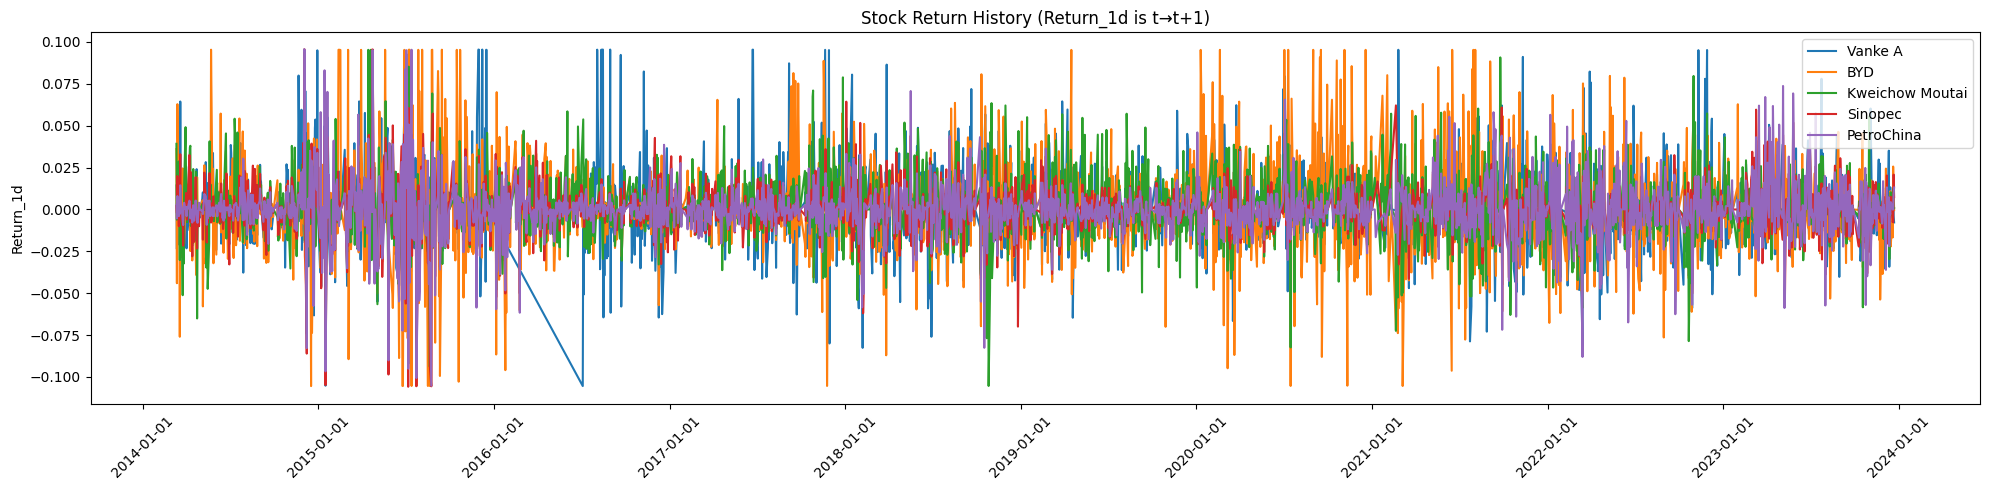

In [7]:
df = pd.read_excel(THESIS_DIR/"data"/"price_news_clean.xlsx")
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
names = ["Vanke A", "BYD", "Kweichow Moutai","Sinopec","PetroChina"] 

fig, ax = plt.subplots(figsize=(20, 5))
for name in names:
    tmp = (
        df[df["Coname"] == name]
        .dropna(subset=["Date", "Return_1d"])
        .sort_values("Date")
    )
    if tmp.empty:
        print(f"[WARN] No data for {name}")
        continue
    ax.plot(tmp["Date"], tmp["Return_1d"], label=name)


ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

ax.set_title("Stock Return History (Return_1d is t→t+1)")
ax.set_ylabel("Return_1d")
plt.xticks(rotation=45)
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [8]:
# Ensure Date is datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Coname", "Date"]).copy()

names = ["Vanke A", "BYD", "Kweichow Moutai", "Sinopec", "PetroChina"]

all_tables = []

for name in names:
    tmp = df[df["Coname"] == name].sort_values("Date").copy()
    if tmp.empty:
        print(f"[WARN] No data for {name}")
        continue

    # Compute gaps between consecutive trading dates
    tmp["gap_days"] = tmp["Date"].diff().dt.days
    gap_counts = (
        tmp["gap_days"]
        .dropna()
        .astype(int)
        .value_counts()
        .sort_index()
    )

    print("\n" + "=" * 60)
    print(f"{name} | rows={len(tmp)} | date range: {tmp['Date'].min().date()} ~ {tmp['Date'].max().date()}")
    print("gap_days frequency (distribution of gaps between consecutive dates):")
    print(gap_counts)

    # Aggregate into a single summary table
    t = gap_counts.rename(name).reset_index()
    t.columns = ["gap_days", "count"]
    all_tables.append(t)

# Merge into a comparison table
if all_tables:
    gap_compare = (
        pd.concat(all_tables, axis=0)
        .pivot_table(
            index="gap_days",
            columns=None,
            values="count",
            aggfunc="sum"
        )
    )



Vanke A | rows=2215 | date range: 2014-03-12 ~ 2023-12-22
gap_days frequency (相邻两条日期间隔的分布):
gap_days
1      1739
2         4
3       397
4        30
5        15
6         7
7         2
8         7
9         1
10        7
11        2
13        1
14        1
199       1
Name: count, dtype: int64

BYD | rows=2348 | date range: 2014-03-12 ~ 2023-12-22
gap_days frequency (相邻两条日期间隔的分布):
gap_days
1     1843
2        5
3      423
4       32
5       16
6        6
7        1
8        7
9        2
10       9
11       2
13       1
Name: count, dtype: int64

Kweichow Moutai | rows=2314 | date range: 2014-03-12 ~ 2023-12-22
gap_days frequency (相邻两条日期间隔的分布):
gap_days
1     1811
2        4
3      391
4       57
5       20
6       10
8        5
9        3
10       8
11       3
12       1
Name: count, dtype: int64

Sinopec | rows=2293 | date range: 2014-03-12 ~ 2023-12-22
gap_days frequency (相邻两条日期间隔的分布):
gap_days
1     1788
2        6
3      385
4       63
5       17
6       10
7        1
8        7
9

In [9]:
# Unified time-based split
def split_by_date_drop_unseen(
    df, train_end, val_end,
    date_col, code_col,
    verbose=True,
    forward_horizon_steps=0,
):
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
    d = d.dropna(subset=[date_col, code_col]).copy()
    d = d.sort_values([code_col, date_col]).reset_index(drop=True)

    if forward_horizon_steps > 0:
        # Use the “future date” to check whether the label crosses the boundary
        d["_next_date"] = d.groupby(code_col)[date_col].shift(-forward_horizon_steps)

        # train: t <= train_end and next_date <= train_end
        train_df = d[
            (d[date_col] <= train_end)
            & (d["_next_date"].notna())
            & (d["_next_date"] <= train_end)
        ].copy()

        # val: train_end < t <= val_end and next_date <= val_end
        val_df = d[
            (d[date_col] > train_end)
            & (d[date_col] <= val_end)
            & (d["_next_date"].notna())
            & (d["_next_date"] <= val_end)
        ].copy()

        # test: t > val_end and next_date exists
        test_df = d[
            (d[date_col] > val_end)
            & (d["_next_date"].notna())
        ].copy()

        train_df.drop(columns=["_next_date"], inplace=True, errors="ignore")
        val_df.drop(columns=["_next_date"], inplace=True, errors="ignore")
        test_df.drop(columns=["_next_date"], inplace=True, errors="ignore")
    else:
        train_df = d[d[date_col] <= train_end].copy()
        val_df = d[(d[date_col] > train_end) & (d[date_col] <= val_end)].copy()
        test_df = d[d[date_col] > val_end].copy()

    # Sort
    train_df = train_df.sort_values([code_col, date_col]).reset_index(drop=True)
    val_df = val_df.sort_values([code_col, date_col]).reset_index(drop=True)
    test_df = test_df.sort_values([code_col, date_col]).reset_index(drop=True)

    if verbose:
        print(
            "Split shapes:",
            "train", train_df.shape,
            "val", val_df.shape,
            "test", test_df.shape
        )

    # Drop unseen codes in validation and test sets
    train_codes = set(train_df[code_col].dropna().unique())
    for name, d in [("val", val_df), ("test", test_df)]:
        unseen = set(d[code_col].dropna().unique()) - train_codes
        if unseen:
            before = len(d)
            d.drop(d[d[code_col].isin(unseen)].index, inplace=True)
            if verbose:
                print(
                    f"Dropped {name} rows from unseen codes: "
                    f"{len(unseen)} codes, rows {before}->{len(d)}"
                )

    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    return train_df, val_df, test_df


## 3. Baseline ARIMA

In [10]:
def adf_test(x, autolag="AIC", alpha=0.05, min_obs=20):
    x = np.asarray(x, dtype=float).reshape(-1)
    x = x[np.isfinite(x)]
    if len(x) < min_obs:
        return {
            "ok": False, "n": int(len(x)), "pvalue": np.nan,
            "stat": np.nan, "crit_1%": np.nan, "crit_5%": np.nan, "crit_10%": np.nan
        }

    try:
        stat, pvalue, usedlag, nobs, crit, icbest = adfuller(x, autolag=autolag)
        return {
            "ok": True,
            "n": int(nobs),
            "usedlag": int(usedlag),
            "stat": float(stat),
            "pvalue": float(pvalue),
            "crit_1%": float(crit.get("1%", np.nan)),
            "crit_5%": float(crit.get("5%", np.nan)),
            "crit_10%": float(crit.get("10%", np.nan)),
            "stationary": bool(pvalue < alpha),
        }
    except Exception:
        return {"ok": False, "n": int(len(x)), "pvalue": np.nan,
                "stat": np.nan, "crit_1%": np.nan, "crit_5%": np.nan, "crit_10%": np.nan}

def select_order_by_aic(train_returns, candidates):
    best_order = None
    best_aic = float("inf")

    for order in candidates:
        try:
            res = ARIMA(train_returns, order=order).fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = order
        except Exception:
            continue

    return best_order, best_aic


In [11]:
scode = "000002"

df["Scode"] = df["Scode"].astype("string").str.replace(r"\.0$", "", regex=True).str.zfill(6)
g = df[df["Scode"].astype(str) == scode].copy()
g["Date"] = pd.to_datetime(g["Date"], errors="coerce")
g["Return_1d"] = pd.to_numeric(g["Return_1d"], errors="coerce")

train_returns = (
    g[g["Date"] <= TRAIN_END]
    .sort_values("Date")["Return_1d"]
    .dropna()
    .to_numpy()
)

adf_res = adf_test(train_returns)
print("ADF pvalue:", adf_res["pvalue"], "| stationary:", adf_res["stationary"])

if adf_res["stationary"]:
    candidates = [(0,0,0),(1,0,0),(0,0,1),(1,0,1),(2,0,1),(1,0,2)]
else:
    candidates = [(0,1,0),(1,1,0),(0,1,1),(1,1,1),(2,1,1),(1,1,2)]

best_order, best_aic = select_order_by_aic(train_returns, candidates)
print("Selected order:", best_order, "AIC:", best_aic)


ADF pvalue: 0.0 | stationary: True
Selected order: (2, 0, 1) AIC: -7039.102493822251


In [24]:
@dataclass
class RollingPred:
    dates: List[pd.Timestamp]
    y_true: List[int]
    y_prob: List[float]

def compute_metrics(y_true, y_prob, threshold = 0.5):
    y_true = np.asarray(y_true).astype(int).reshape(-1)
    y_prob = np.asarray(y_prob).astype(float).reshape(-1)

    m = np.isfinite(y_prob)
    y_true, y_prob = y_true[m], y_prob[m]
    if len(y_true) == 0:
        return {"acc": np.nan, "prec": np.nan, "rec": np.nan, "f1": np.nan,
                "auc": np.nan, "cm": np.array([[np.nan, np.nan],[np.nan, np.nan]]),
                "threshold": threshold}
    y_pred = (y_prob >= threshold).astype(int)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    cm   = confusion_matrix(y_true, y_pred, labels=[0, 1])
    auc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) >= 2 else np.nan
    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc": auc, "cm": cm, "threshold": threshold}

def select_threshold(y_true, y_prob, metric="f1"):
    y_true = np.asarray(y_true).astype(int).reshape(-1)
    y_prob = np.asarray(y_prob).astype(float).reshape(-1)

    m = np.isfinite(y_prob)
    y_true, y_prob = y_true[m], y_prob[m]
    if len(y_true) == 0:
        return 0.5, np.nan
        
    best_t, best_score = 0.5, -1.0
    
    for t in np.linspace(0.05, 0.95, 19):
        y_pred = (y_prob >= t).astype(int)
        score = f1_score(y_true, y_pred, zero_division=0)
        if score > best_score:
            best_score, best_t = float(score), float(t)
    return best_t, best_score

def _make_segments_by_gap(dates, max_gap_days=3):
    dates = pd.to_datetime(dates, errors="coerce").to_numpy(dtype="datetime64[ns]")
    if len(dates) == 0:
        return []
    segs = []
    start = 0
    for i in range(1, len(dates)):
        gap_days = int((dates[i] - dates[i - 1]) / np.timedelta64(1, "D"))
        if gap_days > max_gap_days:
            segs.append((start, i))
            start = i
    segs.append((start, len(dates)))
    return segs

def rolling_forecast_arima_direction(
    g, train_end, val_end,
    order, date_col,
    ret_col="Return_1d",
    max_gap_days=3, min_train_returns=30,
    label_col="y_up_1d",
    eps=EPS,
):
    g = g.sort_values(date_col).copy()
    g[date_col] = pd.to_datetime(g[date_col], errors="coerce")

    if ret_col not in g.columns:
        raise KeyError(f"Missing return column: {ret_col}")
    g[ret_col] = pd.to_numeric(g[ret_col], errors="coerce")
    
    if label_col not in g.columns:
        raise KeyError(f"Missing label column: {label_col}")
    g[label_col] = pd.to_numeric(g[label_col], errors="coerce")

    g = g.dropna(subset=[date_col, ret_col, label_col]).copy()

    out = {
        "train": RollingPred([], [], []),
        "val":   RollingPred([], [], []),
        "test":  RollingPred([], [], []),
    }
    if len(g) < (min_train_returns + 5):
        return out

    dates = g[date_col].to_numpy()
    r_all = g[ret_col].to_numpy(dtype=float)    
    ylab  = g[label_col].to_numpy()  

    # Do not segment; the data already consist of “consecutive trading days”.
    # Segmenting was attempted, but the model ended up producing empty outputs.
    segs = [(0, len(dates))]

    for s, e in segs:
        if e - s < 10:
            continue

        seg_dates = dates[s:e]
        seg_r     = r_all[s:e].copy()
        seg_y     = ylab[s:e].copy()

        train_mask = seg_dates <= np.datetime64(train_end)
        if not train_mask.any():
            continue
        last_train_local = np.where(train_mask)[0].max()

        idx_train = np.where((seg_dates[:-1] <= np.datetime64(train_end)) &
                     (seg_dates[1:]  <= np.datetime64(train_end)))[0]
        if len(idx_train) == 0:
            continue

        train_returns = seg_r[idx_train]
        train_returns = train_returns[np.isfinite(train_returns)]
        if len(train_returns) < min_train_returns:
            continue
        # rolling: start from the last training point
        start_i = int(idx_train.max())

        print("train_returns len =", len(train_returns))

        # Fit ARIMA
        # Disable enforce constraints and increase maxiter during fitting
        try:
            res = ARIMA(
                train_returns,
                order=order,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(method_kwargs={"maxiter": 200})
        except Exception as e:
            print("ARIMA fit failed:", e)
            continue

        # Rolling: at local_i, use history to predict the next period (local_i + 1)
        for local_i in range(start_i, (e - s) - 1):
            next_date = pd.Timestamp(seg_dates[local_i + 1])

            y_true = seg_y[local_i]
            if not np.isfinite(y_true):
                continue
            y_true = int(y_true)

            # Predict the probability that the “next-period return > 0”
            try:
                f = res.get_forecast(steps=1)
                mean = float(np.asarray(f.predicted_mean)[0])
                var = float(np.asarray(f.var_pred_mean)[0])
                se_val = max(np.sqrt(max(var, eps)), eps)
                p_up = float(1.0 - norm.cdf((0.0 - mean) / se_val))
                p_up = min(max(p_up, 0.0), 1.0)
            except Exception:
                p_up = 0.5

            # Assign to bucket based on where next_date (t+1) falls
            if next_date <= train_end:
                bucket = "train"
            elif next_date <= val_end:
                bucket = "val"
            else:
                bucket = "test"

            # Append regardless of which bucket it is
            out[bucket].dates.append(next_date)
            out[bucket].y_true.append(y_true)
            out[bucket].y_prob.append(p_up)

            # Update the model using the realized “next-period return”
            next_r = seg_r[local_i + 1]
            if not np.isfinite(next_r):
                continue
            try:
                res = res.append([float(next_r)], refit=False)
            except Exception:
                continue

    print("n_pred:", {k: len(out[k].dates) for k in ["train", "val", "test"]})
    return out


In [25]:
def arima_predict(
    df_all, scode,
    train_end, val_end,
    order,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d",
    label_col="y_up_1d",
    max_gap_days=3, min_train_returns=30, eps=1e-8,
):
    g = df_all[df_all[code_col].astype(str) == str(scode)].copy()

    out = rolling_forecast_arima_direction(
        g, train_end, val_end,
        order=order,
        date_col=date_col,
        ret_col=ret_col,           
        max_gap_days=max_gap_days,
        min_train_returns=min_train_returns,
        label_col=label_col,       
        eps=eps
    )

    rows = []
    for split in ["train", "val", "test"]:
        rp = out[split]
        for d, y, p in zip(rp.dates, rp.y_true, rp.y_prob):
            rows.append({
                "Scode": str(scode),
                "Date": d,
                "split": split,
                "y_true": int(y),
                "p_up": float(p),
            })

    pred_df = pd.DataFrame(rows)
    if not pred_df.empty:
        pred_df = pred_df.sort_values("Date").reset_index(drop=True)
    return pred_df

def evaluate_pred_df(pred_df, threshold=None, pick_on="val", metric="f1"):
    if pred_df is None or pred_df.empty:
        base = {"threshold": np.nan, "acc": np.nan, "prec": np.nan, "rec": np.nan,
                "f1": np.nan, "auc": np.nan, "tn": np.nan, "fp": np.nan, "fn": np.nan, "tp": np.nan}
        return {"threshold": np.nan, "train": base, "val": base, "test": base}

    d_pick = pred_df[pred_df["split"] == pick_on]
    y_pick_true = d_pick["y_true"].to_numpy(dtype=int)
    y_pick_prob = d_pick["p_up"].to_numpy(dtype=float)

    if threshold is None:
        best_t, _ = select_threshold(y_pick_true, y_pick_prob, metric=metric)
    else:
        best_t = float(threshold)

    metrics_by_split = {}
    for sp in ["train", "val", "test"]:
        d = pred_df[pred_df["split"] == sp]
        m = compute_metrics(d["y_true"].to_numpy(int), d["p_up"].to_numpy(float), threshold=best_t)
        metrics_by_split[sp] = m

    return {"threshold": best_t, **metrics_by_split}

def arima_predict_with_metrics(
    df_all, scode, train_end, val_end, order,
    date_col="Date", code_col="Scode", ret_col="Return_1d", label_col="y_up_1d",
    min_train_returns=30, eps=EPS,
    threshold=None, pick_on="val"
):
    pred_df = arima_predict(
        df_all=df_all, scode=scode,
        train_end=train_end, val_end=val_end,
        order=order,
        date_col=date_col, code_col=code_col,
        ret_col=ret_col, label_col=label_col,
        min_train_returns=min_train_returns, eps=eps
    )
    metrics = evaluate_pred_df(pred_df, threshold=threshold, pick_on=pick_on)
    return pred_df, metrics

def plot_arima(
    df_all, pred_df,
    train_end, val_end,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d",
    threshold=None,
    title_prefix="ARIMA rolling P(up)"
):
    if pred_df is None or pred_df.empty:
        print("pred_df is empty: no predictions to plot.")
        return

    scode = pred_df["Scode"].iloc[0]
    g = df_all[df_all[code_col].astype(str) == str(scode)].copy()
    g[date_col] = pd.to_datetime(g[date_col], errors="coerce")
    g[ret_col] = pd.to_numeric(g[ret_col], errors="coerce")
    g = g.dropna(subset=[date_col, ret_col]).sort_values(date_col)

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # True Return_1d (left axis)
    ax1.plot(g[date_col], g[ret_col], label=ret_col)
    ax1.set_xlabel("Date")
    ax1.set_ylabel(ret_col)

    # Split lines
    ax1.axvline(pd.Timestamp(train_end), linestyle="--", label="TRAIN_END")
    ax1.axvline(pd.Timestamp(val_end), linestyle="--", label="VAL_END")

    # p_up (right axis)
    ax2 = ax1.twinx()
    ax2.set_ylabel("P(up)")

    for split, marker in [("train", "."), ("val", "o"), ("test", "s")]:
        d = pred_df[pred_df["split"] == split]
        if len(d):
            ax2.plot(
                d["Date"], d["p_up"],
                linestyle="None", marker=marker,
                label=f"p_up ({split})", alpha=0.8
            )

    if threshold is not None:
        ax2.axhline(float(threshold), linestyle=":", label=f"thr={threshold:.2f}")

    # Merge legends
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left")

    ax1.set_title(f"{title_prefix} | Scode={scode}")
    plt.tight_layout()
    plt.show()


train_returns len = 1525
n_pred: {'train': 1, 'val': 453, 'test': 236}
Best threshold (picked on val): 0.49999999999999994
VAL : {'acc': 0.5805739514348786, 'prec': 0.5178082191780822, 'rec': 0.9310344827586207, 'f1': 0.6654929577464789, 'auc': 0.797576354679803, 'cm': array([[ 74, 176],
       [ 14, 189]]), 'threshold': 0.49999999999999994}
TEST: {'acc': 0.4322033898305085, 'prec': 0.38095238095238093, 'rec': 0.9523809523809523, 'f1': 0.54421768707483, 'auc': 0.8473527568922306, 'cm': array([[ 22, 130],
       [  4,  80]]), 'threshold': 0.49999999999999994}


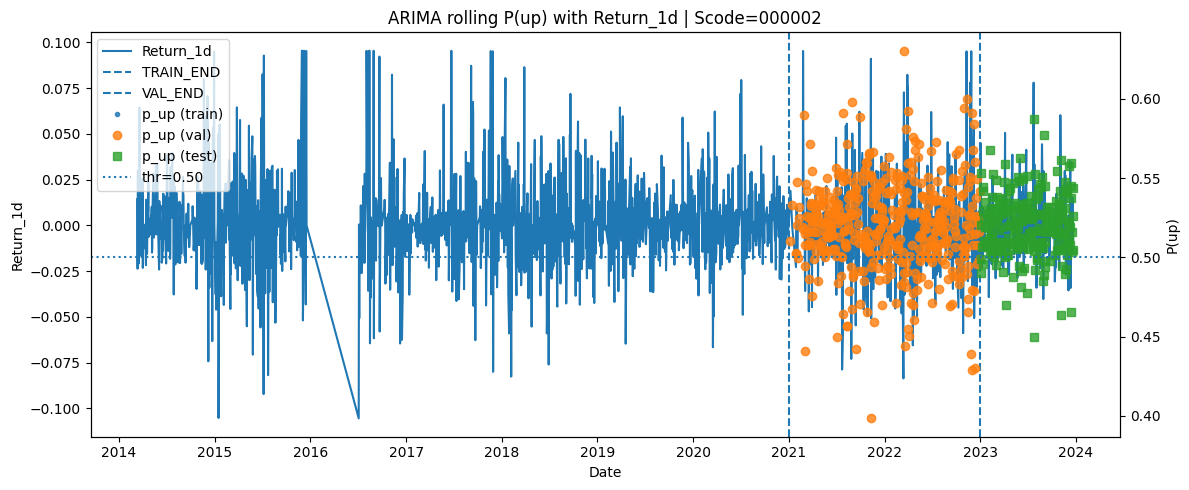

In [26]:
scode = "000002"

pred_df, metrics = arima_predict_with_metrics(
    df_all=df, scode=scode,
    train_end=TRAIN_END, val_end=VAL_END,
    order=best_order,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d", label_col="y_up_1d",
    min_train_returns=30, eps=EPS,
    threshold=None, pick_on="val"
)

print("Best threshold (picked on val):", metrics["threshold"])
print("VAL :", metrics["val"])
print("TEST:", metrics["test"])

plot_arima(
    df_all=df, pred_df=pred_df,
    train_end=TRAIN_END, val_end=VAL_END,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d",
    threshold=metrics["threshold"],
    title_prefix="ARIMA rolling P(up) with Return_1d"
)


In [44]:
def arima_predict_all(
    df_all,
    train_end, val_end,
    order,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d",
    label_col="y_up_1d",
    max_gap_days=3, min_train_returns=30, eps=1e-8,
    codes=None,
    verbose=True
):
    # If codes=None, automatically run for all firms in df_all
    if codes is None:
        codes = sorted(df_all[code_col].dropna().astype(str).unique().tolist())
    else:
        codes = [str(c) for c in codes]

    all_pred = []
    for scode in codes:
        pred_df = arima_predict(
            df_all=df_all, scode=scode,
            train_end=train_end, val_end=val_end,
            order=order,
            date_col=date_col, code_col=code_col,
            ret_col=ret_col, label_col=label_col,
            max_gap_days=max_gap_days, min_train_returns=min_train_returns, eps=eps
        )
        if verbose:
            print(f"[ARIMA] {scode}: n_pred={len(pred_df)}")
        if pred_df is not None and len(pred_df) > 0:
            all_pred.append(pred_df)

    if len(all_pred) == 0:
        return pd.DataFrame(columns=["Scode", "Date", "split", "y_true", "p_up"])

    pred_df_all = pd.concat(all_pred, ignore_index=True)
    pred_df_all = pred_df_all.sort_values(["Scode", "Date"]).reset_index(drop=True)
    return pred_df_all


def arima_predict_all_with_metrics(
    df_all,
    train_end, val_end,
    order,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d",
    label_col="y_up_1d",
    max_gap_days=3, min_train_returns=30, eps=EPS,
    codes=None,
    pick_on="val",
    verbose=True
):
    pred_df_all = arima_predict_all(
        df_all=df_all,
        train_end=train_end, val_end=val_end,
        order=order,
        date_col=date_col, code_col=code_col,
        ret_col=ret_col, label_col=label_col,
        max_gap_days=max_gap_days, min_train_returns=min_train_returns, eps=eps,
        codes=codes,
        verbose=verbose
    )

    # Evaluate each firm separately (each firm selects its own threshold)
    metrics_by_code = {}
    for scode, g in pred_df_all.groupby("Scode"):
        metrics_by_code[scode] = evaluate_pred_df(
            g, threshold=None, pick_on=pick_on
        )

    # Global evaluation (all firms jointly select one threshold based on validation set)
    metrics_global = evaluate_pred_df(
        pred_df_all, threshold=None, pick_on=pick_on
    )

    return pred_df_all, metrics_by_code, metrics_global


In [45]:
pred_df_all, metrics_by_code, metrics_global = arima_predict_all_with_metrics(
    df_all=df,
    train_end=TRAIN_END, val_end=VAL_END,
    order=best_order,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d", label_col="y_up_1d",
    min_train_returns=30, eps=EPS,
    codes=None,          # all companydef arima_predict_all(
    df_all,
    train_end, val_end,
    order,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d",
    label_col="y_up_1d",
    max_gap_days=3, min_train_returns=30, eps=1e-8,
    codes=None,
    verbose=True
):
    # If codes=None, automatically run for all firms in df_all
    if codes is None:
        codes = sorted(df_all[code_col].dropna().astype(str).unique().tolist())
    else:
        codes = [str(c) for c in codes]

    all_pred = []
    for scode in codes:
        pred_df = arima_predict(
            df_all=df_all, scode=scode,
            train_end=train_end, val_end=val_end,
            order=order,
            date_col=date_col, code_col=code_col,
            ret_col=ret_col, label_col=label_col,
            max_gap_days=max_gap_days, min_train_returns=min_train_returns, eps=eps
        )
        if verbose:
            print(f"[ARIMA] {scode}: n_pred={len(pred_df)}")
        if pred_df is not None and len(pred_df) > 0:
            all_pred.append(pred_df)

    if len(all_pred) == 0:
        return pd.DataFrame(columns=["Scode", "Date", "split", "y_true", "p_up"])

    pred_df_all = pd.concat(all_pred, ignore_index=True)
    pred_df_all = pred_df_all.sort_values(["Scode", "Date"]).reset_index(drop=True)
    return pred_df_all


def arima_predict_all_with_metrics(
    df_all,
    train_end, val_end,
    order,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d",
    label_col="y_up_1d",
    max_gap_days=3, min_train_returns=30, eps=EPS,
    codes=None,
    pick_on="val",
    verbose=True
):
    pred_df_all = arima_predict_all(
        df_all=df_all,
        train_end=train_end, val_end=val_end,
        order=order,
        date_col=date_col, code_col=code_col,
        ret_col=ret_col, label_col=label_col,
        max_gap_days=max_gap_days, min_train_returns=min_train_returns, eps=eps,
        codes=codes,
        verbose=verbose
    )

    # Evaluate each firm separately (each firm selects its own threshold)
    metrics_by_code = {}
    for scode, g in pred_df_all.groupby("Scode"):
        metrics_by_code[scode] = evaluate_pred_df(
            g, threshold=None, pick_on=pick_on
        )

    # Global evaluation (all firms jointly select one threshold based on validation set)
    metrics_global = evaluate_pred_df(
        pred_df_all, threshold=None, pick_on=pick_on
    )

    return pred_df_all, metrics_by_code, metrics_global

    pick_on="val",
    verbose=True
)

print("GLOBAL best threshold:", metrics_global["threshold"])
print("GLOBAL VAL :", metrics_global["val"])
print("GLOBAL TEST:", metrics_global["test"])


train_returns len = 1525
n_pred: {'train': 1, 'val': 453, 'test': 236}
[ARIMA] 000002: n_pred=690
train_returns len = 1647
n_pred: {'train': 1, 'val': 463, 'test': 237}
[ARIMA] 002594: n_pred=701
train_returns len = 1623
n_pred: {'train': 1, 'val': 438, 'test': 231}
[ARIMA] 600028: n_pred=670
train_returns len = 1613


/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


n_pred: {'train': 1, 'val': 466, 'test': 234}
[ARIMA] 600519: n_pred=701
train_returns len = 1650
n_pred: {'train': 1, 'val': 458, 'test': 234}
[ARIMA] 601857: n_pred=693
GLOBAL best threshold: 0.49999999999999994
GLOBAL VAL : {'acc': 0.6053555750658473, 'prec': 0.5452145214521452, 'rec': 0.7972972972972973, 'f1': 0.6475891807134457, 'auc': 0.6811244474287953, 'cm': array([[553, 689],
       [210, 826]]), 'threshold': 0.49999999999999994}
GLOBAL TEST: {'acc': 0.5418088737201365, 'prec': 0.4809069212410501, 'rec': 0.7980198019801981, 'f1': 0.6001489203276247, 'auc': 0.6387073789837755, 'cm': array([[232, 435],
       [102, 403]]), 'threshold': 0.49999999999999994}


## 4. Feature Engineering

In [27]:
train_df, val_df, test_df = split_by_date_drop_unseen(
    df,
    train_end=TRAIN_END,   、
    val_end=VAL_END,       
    date_col="Date",
    code_col="Scode",
    forward_horizon_steps=1,  
    verbose=True
)

print("train:", train_df["Date"].min(), "~", train_df["Date"].max())
print("val:",   val_df["Date"].min(),   "~", val_df["Date"].max())
print("test:",  test_df["Date"].min(),  "~", test_df["Date"].max())


Split shapes: train (8058, 48) val (2273, 48) test (1167, 48)
train: 2014-03-12 00:00:00 ~ 2020-12-30 00:00:00
val: 2021-01-06 00:00:00 ~ 2022-12-29 00:00:00
test: 2023-01-03 00:00:00 ~ 2023-12-21 00:00:00


In [32]:
# Missing-value handling: missing mask -> per-stock forward fill -> train-only imputation
for c in FEATURE_COLS:
    train_df[c + "_miss"] = train_df[c].isna().astype(int)
    val_df[c + "_miss"] = val_df[c].isna().astype(int)
    test_df[c + "_miss"] = test_df[c].isna().astype(int)

# Subsequent steps include clip/log1p/scale; convert to float uniformly
# to avoid warnings when writing int64 back to float
for d in [train_df, val_df, test_df]:
    d[FEATURE_COLS] = d[FEATURE_COLS].astype("float64")

price_cols = [c for c in FEATURE_COLS if c not in SENT_COLS]

train_df[price_cols] = train_df.groupby("Scode")[price_cols].ffill()
val_df[price_cols]   = val_df.groupby("Scode")[price_cols].ffill()
test_df[price_cols]  = test_df.groupby("Scode")[price_cols].ffill()

for d in [train_df, val_df, test_df]:
    d[SENT_COLS] = d[SENT_COLS].fillna(0)

train_median = train_df[price_cols].median(numeric_only=True)
train_df[price_cols] = train_df[price_cols].fillna(train_median)
val_df[price_cols]   = val_df[price_cols].fillna(train_median)
test_df[price_cols]  = test_df[price_cols].fillna(train_median)

def assert_finite(name, d, cols):
    arr = d[cols].values
    if not np.isfinite(arr).all():
        bad = np.argwhere(~np.isfinite(arr))
        raise ValueError(
            f"[{name}] Found non-finite values in features. "
            f"Example index: {bad[:5]}"
        )

assert_finite("train(pre-clip)", train_df, FEATURE_COLS)
assert_finite("val(pre-clip)", val_df, FEATURE_COLS)
assert_finite("test(pre-clip)", test_df, FEATURE_COLS)

# Extreme-value handling: train-only thresholds, then applied to val/test;
# apply log1p first, then clip
for col in LOG_TARGETS:
    if col in FEATURE_COLS:
        train_df[col] = np.log1p(train_df[col].clip(lower=0))
        val_df[col]   = np.log1p(val_df[col].clip(lower=0))
        test_df[col]  = np.log1p(test_df[col].clip(lower=0))

code_thresholds = {}
global_low = train_df[FEATURE_COLS].quantile(0.01)
global_high = train_df[FEATURE_COLS].quantile(0.99)
global_high = np.maximum(global_high, global_low)

for code, g in train_df.groupby("Scode"):
    if len(g) >= MIN_TRAIN_ROWS_PER_CODE:
        low = g[FEATURE_COLS].quantile(0.01).fillna(global_low)
        high = g[FEATURE_COLS].quantile(0.99).fillna(global_high)
    else:
        low, high = global_low, global_high
    high = np.maximum(high, low)
    code_thresholds[code] = (low, high)

def apply_clip(d: pd.DataFrame) -> pd.DataFrame:
    d = d.copy()
    for code, idx in d.groupby("Scode").groups.items():
        low, high = code_thresholds.get(code, (global_low, global_high))
        d.loc[idx, FEATURE_COLS] = d.loc[idx, FEATURE_COLS].clip(
            lower=low, upper=high, axis=1
        )
    return d

train_df = apply_clip(train_df)
val_df   = apply_clip(val_df)
test_df  = apply_clip(test_df)

assert_finite("train(post-clip)", train_df, FEATURE_COLS)
assert_finite("val(post-clip)", val_df, FEATURE_COLS)
assert_finite("test(post-clip)", test_df, FEATURE_COLS)

# Standardization: per-company scaler trained on train only, fallback to global
global_scaler = StandardScaler()
global_scaler.fit(train_df[FEATURE_COLS].values)

scalers = {}
stats = {"ok": 0, "fallback_global": 0}

for code, g in train_df.groupby("Scode"):
    idx_train = g.index
    train_data = train_df.loc[idx_train, FEATURE_COLS].values

    if train_data.shape[0] < MIN_TRAIN_ROWS_PER_CODE:
        train_df.loc[idx_train, FEATURE_COLS] = global_scaler.transform(train_data)

        for d in [val_df, test_df]:
            idx = d.index[d["Scode"] == code]
            if len(idx) > 0:
                d.loc[idx, FEATURE_COLS] = global_scaler.transform(
                    d.loc[idx, FEATURE_COLS].values
                )

        stats["fallback_global"] += 1
        continue

    if np.min(np.std(train_data, axis=0)) < EPS:
        train_df.loc[idx_train, FEATURE_COLS] = global_scaler.transform(train_data)
        stats["fallback_global"] += 1
        continue

    sc = StandardScaler()
    sc.fit(train_data)
    scalers[code] = sc
    stats["ok"] += 1

    train_df.loc[idx_train, FEATURE_COLS] = sc.transform(train_data)

    for d in [val_df, test_df]:
        idx = d.index[d["Scode"] == code]
        if len(idx) > 0:
            d.loc[idx, FEATURE_COLS] = sc.transform(
                d.loc[idx, FEATURE_COLS].values
            )

print("scaler summary:", stats)

assert_finite("train(post-scale)", train_df, FEATURE_COLS)
assert_finite("val(post-scale)", val_df, FEATURE_COLS)
assert_finite("test(post-scale)", test_df, FEATURE_COLS)

print("Ready for model training (features standardized, safe-imputed).")


scaler summary: {'ok': 0, 'fallback_global': 5}
Ready for model training (features standardized, safe-imputed).


In [49]:
# build windows 
def make_windows(df_part, feature_cols, lag, code_col="Scode", date_col="Date", label_col="y_up_1d"):
    X_list, y_list, scode_list, date_list = [], [], [], []

    for scode, g in df_part.groupby(code_col):
        g = g.sort_values(date_col).reset_index(drop=True)
        if len(g) < lag:
            continue

        Xg = g[feature_cols].to_numpy(dtype=np.float32)                 # (T, F)
        yg = g[label_col].to_numpy(dtype=np.int64)                      # (T,)
        dg = pd.to_datetime(g[date_col]).to_numpy(dtype="datetime64[ns]")  # (T,)

        for end in range(lag - 1, len(g)):
            start = end - lag + 1
            X_list.append(Xg[start:end + 1])     # (lag, F)
            y_list.append(yg[end])               # label aligned to end
            scode_list.append(str(scode))
            date_list.append(dg[end])            # the Date corresponding to end

    if len(X_list) == 0:
        X = torch.empty((0, lag, len(feature_cols)), dtype=torch.float32)
        y = torch.empty((0,), dtype=torch.long)
        sc = torch.empty((0,), dtype=torch.long)
        dt = torch.empty((0,), dtype=torch.long)
        return TensorDataset(X, y, sc, dt), {}, {}

    # scode -> id
    uniq_codes = sorted(set(scode_list))
    code2id = {c: i for i, c in enumerate(uniq_codes)}
    id2code = {i: c for c, i in code2id.items()}

    scode_id = np.array([code2id[c] for c in scode_list], dtype=np.int64)
    date_ns  = np.array(date_list, dtype="datetime64[ns]").astype("int64")

    X = torch.from_numpy(np.stack(X_list)).float()
    y = torch.from_numpy(np.array(y_list)).long()
    sc = torch.from_numpy(scode_id).long()
    dt = torch.from_numpy(date_ns).long()

    return TensorDataset(X, y, sc, dt), code2id, id2code

train_set, code2id, id2code = make_windows(train_df, FEATURE_COLS, LAG)
val_set,   _,      _        = make_windows(val_df,   FEATURE_COLS, LAG)
test_set,  _,      _        = make_windows(test_df,  FEATURE_COLS, LAG)

print("Train/Val/Test windows:", len(train_set), len(val_set), len(test_set))
if len(train_set) > 0:
    print("One sample:", train_set[0][0].shape, train_set[0][1].shape)
else:
    print("train_set is empty")

Train/Val/Test windows: 8038 2253 1147
One sample: torch.Size([5, 29]) torch.Size([])


In [50]:
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

# 3. Intra-modal feature extraction

## 3.1 Price modality: the LSTM encoder extracts temporal features

In [35]:
n_price = len(price_cols)
n_news  = len(SENT_COLS)

class PriceLSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            num_layers=1, 
        )

    def forward(self, x_price):
        """
        x_price: (B, L, D_price)
        return:  (B, hidden_dim)
        """
        out, (h_n, c_n) = self.lstm(x_price)
        h_price = h_n[-1]   # (B, hidden_dim)
        return h_price

## 3.2 News modality: the MLP encoder extracts a nonlinear sentiment representation

In [36]:
class NewsMLPEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=16, out_dim=32, dropout=0.5):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, out_dim),
            nn.ReLU()
        )

    def forward(self, x_news):
        B, L, D = x_news.shape
        z = self.mlp(x_news.reshape(B * L, D))     # (B*L, out_dim)
        z = z.view(B, L, -1)                   # (B, L, out_dim)
        h_news = z.mean(dim=1)                    # (B, out_dim)  mean pooling
        return h_news

# 4.Early Fusion Predictor

In [37]:
class EarlyFusionPredictor(nn.Module):
    """
    input: X = (B, L, D_total) where D_total = n_price + n_news
    slicing: X[..., :n_price] -> x_price
             X[..., n_price:] -> x_news
    fusion: concat(h_price, h_news) -> MLP -> output
    """
    def __init__(self, n_price, n_news, price_hidden_dim=32, news_out_dim=32, fusion_hidden_dim=32, dropout=0.5):
        super().__init__()
        self.n_price = n_price
        self.n_news  = n_news

        self.price_encoder = PriceLSTMEncoder(input_dim=n_price,hidden_dim=price_hidden_dim)
        self.news_encoder = NewsMLPEncoder(input_dim=n_news,hidden_dim=16,out_dim=news_out_dim,dropout=dropout)

        fusion_in_dim = price_hidden_dim + news_out_dim
        self.norm = nn.LayerNorm(fusion_in_dim) 

        self.head = nn.Sequential(
            nn.Linear(fusion_in_dim, fusion_hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_hidden_dim, 2)  
        )

    def forward(self, X):
        # X: (B, L, n_price+n_news)
        x_price = X[..., :self.n_price]           # (B, L, n_price)
        x_news  = X[..., self.n_price:self.n_price+self.n_news]  # (B, L, n_news)

        h_price = self.price_encoder(x_price)     # (B, price_hidden_dim)
        h_news  = self.news_encoder(x_news)       # (B, news_out_dim)

        h = torch.cat([h_price, h_news], dim=-1)  # early fusion
        h = self.norm(h)
        return self.head(h)                       # (B, out_dim)


In [38]:
class MidFusionPredictor(nn.Module):
    """
    Mid-level fusion with Cross-Attention (price as Q, news as K/V):
    1) price -> LSTM -> Hp_seq: (B,L,Hp)
    2) news  -> MLP  -> Hn_seq: (B,L,Hn)
    3) Project to the same dimension d_model, X: (B, L, Dtotal), Dtotal = n_price + n_news
    4) Q = proj(price), K/V = news
    5) CrossAttention: attn_out = MHA(Q=price, K=news, V=news) -> (B,L,d_model)
    6) Residual + LayerNorm, then sequence aggregation to (B,*): mean pooling
    7) head -> logits (B,1)
    """
    def __init__(
        self, n_price, n_news,
        price_hidden_dim = 32, news_hidden_dim = 16,
        d_model = 32, num_heads = 4, dropout = 0.5,
    ):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.n_price = n_price
        self.n_news  = n_news
        
        # Intermediate representations of the two modalities
        self.price_seq = nn.LSTM(n_price, price_hidden_dim, batch_first=True)
        self.news_seq  = nn.Sequential(
            nn.Linear(n_news, news_hidden_dim), 
            nn.ReLU(), 
            nn.Dropout(dropout), 
            nn.Linear(news_hidden_dim, d_model)
        )
        # Map price Hp to d_model to ensure Q, K, V have the same dimension
        self.price_proj = nn.Linear(price_hidden_dim, d_model)

        # Cross-Attention
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )

        self.attn_drop = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.head = nn.Sequential(
        nn.Linear(d_model, d_model),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(d_model, 2)
        )


    def forward(self, X):
        # X: (B,L,Dtotal) where Dtotal = n_price + n_news
        x_price = X[..., :self.n_price]  # (B,L,n_price)
        x_news  = X[..., self.n_price:self.n_price + self.n_news]  # (B,L,n_news)

        # Encoding
        hp_seq, _ = self.price_seq(x_price)          # (B,L,Hp)
        B, L, Dn = x_news.shape
        hn_seq = self.news_seq(x_news.reshape(-1, Dn)).reshape(B, L, -1)            # (B,L,d_model)

        q = self.price_proj(hp_seq)               # (B,L,d_model)
        k = hn_seq                                # (B,L,d_model)
        v = hn_seq                                # (B,L,d_model)

        # Cross-Attention
        attn_out, _ = self.cross_attn(q, k, v)    # (B,L,d_model)

        # Residual fusion + normalization
        h = self.norm1(q + self.attn_drop(attn_out))  # (B,L,d_model)
        # Pooling
        z = h.mean(dim=1)           # (B,d_model)
        z = self.norm2(z)

        return self.head(z)         # (B,2)


In [39]:
# Price branch: use only price features to output price_logit
class PriceOnlyPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, 2)  
        )

    def forward(self, x_price):
        # x_price: (B,L,Dp)
        _, (h_n, _) = self.lstm(x_price)
        h = h_n[-1]                # (B,hidden_dim)
        return self.head(h)        # (B,2) price_logit


# News branch: use only news features to output news_logit 
class NewsOnlyPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=16, out_dim=16, dropout=0.5):
        super().__init__()
        self.step_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, out_dim),
            nn.ReLU()
        )
        self.head = nn.Sequential(
            nn.Linear(out_dim, out_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(out_dim, 2) 
        )

    def forward(self, x_news):
        # x_news: (B,L,Dn)
        B, L, D = x_news.shape
        z = self.step_mlp(x_news.contiguous().view(B * L, D))  # (B*L,out_dim)
        z = z.reshape(B, L, -1)                      # (B,L,out_dim)
        h = z.mean(dim=1)                            # (B,out_dim) mean pooling over time first
        return self.head(h)                          # (B,2) 


# Late fusion: fuse the two branches' "prediction outputs" 
class LateFusionPredictor(nn.Module):
    """
    Weighted late fusion on logits:
    final_logits = w0 * price_logits + w1 * news_logits + b
    where w = softmax([w0_raw, w1_raw]).
    """
    def __init__(self, n_price, n_news, price_hidden=32, news_hidden=16, news_out=16, dropout=0.5):
        super().__init__()

        self.n_price = n_price
        self.n_news = n_news

        self.price_model = PriceOnlyPredictor(input_dim=n_price, hidden_dim=price_hidden)
        self.news_model  = NewsOnlyPredictor(input_dim=n_news, hidden_dim=news_hidden, out_dim=news_out, dropout=dropout)

        # Modality weights (raw); transformed by softmax during training to be positive and sum to 1
        self.w = nn.Parameter(torch.tensor([0.0, 0.0], dtype=torch.float32))  # initial softmax is [0.5, 0.5]
        # One bias per class
        self.bias = nn.Parameter(torch.zeros(2, dtype=torch.float32))

    def forward(self, X):
        # X: (B,L,Dtotal)
        x_price = X[..., :self.n_price]
        x_news  = X[..., self.n_price:self.n_price+self.n_news]

        price_logit = self.price_model(x_price)  
        news_logit  = self.news_model(x_news)     

        w = torch.softmax(self.w, dim=0)         
        final_logits = w[0] * price_logit + w[1] * news_logit + self.bias  
        return final_logits


In [92]:
def Loss_function(train_set, device):
        
    y = train_set.tensors[1].long()
    pos = (y == 1).sum().item()
    neg = (y == 0).sum().item()
    pos_w = min(neg / max(pos, 1), 10.0)
    if pos > 0 and neg > 0:
        w = torch.tensor([1.0, pos_w], dtype=torch.float32, device=device)
        return nn.CrossEntropyLoss(weight=w)
    return nn.CrossEntropyLoss()
    
def train_one_epoch(model, loader, optimizer, criterion, device, clip_norm=1.0):
    model.train()
    total_loss, total_n = 0.0, 0
    for batch in loader:
        X = batch[0].to(device)
        y = batch[1].to(device).long()

        optimizer.zero_grad()
        logits = model(X)              
        loss = criterion(logits, y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_norm)
        optimizer.step()

        bs = y.size(0)
        total_loss += loss.item() * bs
        total_n += bs
    return total_loss / total_n

@torch.no_grad()
def eval_loss(model, loader, criterion, device):
    model.eval()
    total_loss, total_n = 0.0, 0
    for batch in loader:
        X = batch[0].to(device)              # (B,L,F)
        y = batch[1].to(device).long() 
        
        logits = model(X)              # (B,2)
        loss = criterion(logits, y)
        bs = y.size(0)
        total_loss += loss.item() * bs
        total_n += bs
    return total_loss / total_n
    

In [99]:
@torch.no_grad()
def collect_probs(model, loader, device):
    model.eval()
    y_true_list, y_prob_list = [], []
    for batch in loader:
        X = batch[0].to(device)
        y = batch[1]

        logits = model(X)                          
        probs = torch.softmax(logits, dim=1)[:, 1] 
        
        y_true_list.append(y.detach().cpu().numpy().astype(int))
        y_prob_list.append(probs.detach().cpu().numpy().astype(float))
        
    y_true = np.concatenate(y_true_list).astype(int)
    y_prob = np.concatenate(y_prob_list).astype(float)
    return y_true, y_prob

def train_select(
    model_name,
    model,
    train_set,
    train_loader, val_loader, test_loader,
    epochs=100, lr=1e-4, threshold=0.5,
    clip_norm=1.0, patience=15, device=None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = Loss_function(train_set, device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2) 

    best_val_loss = float("inf")
    best_state = None
    history = []

    # Early Stopping Variables
    patience_counter = 0
    for epoch in range(1, epochs + 1):
        tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, device, clip_norm=clip_norm)
        va_loss = eval_loss(model, val_loader, criterion, device)

        # Check for improvement
        if va_loss < best_val_loss:
            best_val_loss = va_loss
            best_state = copy.deepcopy(model.state_dict())
            patience_counter = 0  # Reset counter if improvement found
        else:
            patience_counter += 1 # Increment counter if no improvement

        history.append({"epoch": epoch, "train_loss": tr_loss, "val_loss": va_loss})
        print(f"[{model_name}] Epoch {epoch:02d} | Train {tr_loss:.4f} | Val {va_loss:.4f} | BestVal {best_val_loss:.4f}")

        # Check Early Stopping condition
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}!")
            break
    if best_state is not None:
        model.load_state_dict(best_state)

    # best val loss
    yv_true, yv_prob = collect_probs(model, val_loader, device)
    
    # Select the threshold using the validation set, then evaluate the test set using the same threshold
    best_t, best_score = select_threshold(yv_true, yv_prob)

    yt_true, yt_prob = collect_probs(model, test_loader, device)
    val_metrics = compute_metrics(yv_true, yv_prob, threshold=best_t)
    test_metrics = compute_metrics(yt_true, yt_prob, threshold=best_t)

    val_metrics["threshold"] = best_t
    test_metrics["threshold"] = best_t

    return model, pd.DataFrame(history), best_val_loss, val_metrics, test_metrics


In [100]:
def run_models(
    n_price, n_news,
    train_set, train_loader, val_loader, test_loader,
    epochs=100, lr=1e-4, threshold=0.5, patience=15, device=None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    models = {
        "Early": EarlyFusionPredictor(
            n_price, n_news, 
            price_hidden_dim=32, news_out_dim=32, fusion_hidden_dim=32, 
            dropout=0.5
        ),
        "Mid": MidFusionPredictor(
            n_price=n_price, n_news=n_news, 
            price_hidden_dim=32, news_hidden_dim=16, 
            d_model=32, num_heads=4, 
            dropout=0.5
        ),
        "Late": LateFusionPredictor(
            n_price=n_price, n_news=n_news, 
            price_hidden=32, news_hidden=16, news_out=16, 
            dropout=0.5
        ),
    }

    results = []
    trained_models = {}
    histories = {}

    for name, model in models.items():
        print("\n" + "="*60)
        print(f"Training {name} (select best by min val loss)")
        print("="*60)

        trained_model, hist_df, best_val_loss, val_m, test_m = train_select(
            model_name=name,
            model=model,
            train_set=train_set,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            epochs=epochs,
            lr=lr,
            threshold=threshold,
            patience=patience,
            device=device
        )

        trained_models[name] = trained_model
        histories[name] = hist_df

        results.append({
            "model": name,
            "best_val_loss": best_val_loss,
            "val": val_m,
            "test": test_m
        })

    # Build summary table
    rows = []
    split_order = {"val": 0, "test": 1}

    for r in results:
        for split in ["val", "test"]:
            m = r.get(split, {})

            # If the threshold does not exist, use the default value passed in
            used_thr = m.get("threshold", threshold)
            cm = m.get("cm", None)
            if isinstance(cm, np.ndarray) and cm.shape == (2, 2):
                tn, fp = int(cm[0, 0]), int(cm[0, 1])
                fn, tp = int(cm[1, 0]), int(cm[1, 1])
            else:
                tn = fp = fn = tp = np.nan
                
            rows.append({
                "model": r["model"],
                "split": split,
                "split_rank": split_order.get(split, 99),
                "best_val_loss": r["best_val_loss"],
                "threshold": used_thr,
                "acc": m.get("acc", np.nan),
                "prec": m.get("prec", np.nan),
                "rec": m.get("rec", np.nan),
                "f1": m.get("f1", np.nan),
                "auc": m.get("auc", np.nan),
                "tn": tn, "fp": fp, "fn": fn, "tp": tp
            })
            
    summary_df = pd.DataFrame(rows)
    summary_df = summary_df.sort_values(["split_rank", "f1"], ascending=[True, False]).reset_index(drop=True)
    summary_df = summary_df.drop(columns=["split_rank"])

    test_df = summary_df[summary_df["split"] == "test"].sort_values("f1", ascending=False).reset_index(drop=True)
    
    return results, summary_df, test_df, trained_models, histories


In [101]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results, df_results, df_test, trained_models, histories = run_models(
    n_price=n_price,
    n_news=n_news,
    train_set=train_set,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=100,
    lr=1e-4,
    threshold=0.5,
    patience=15,
    device=device
)



Training Early (select best by min val loss)
[Early] Epoch 01 | Train 0.7106 | Val 0.6997 | BestVal 0.6997
[Early] Epoch 02 | Train 0.7024 | Val 0.7005 | BestVal 0.6997
[Early] Epoch 03 | Train 0.7002 | Val 0.7018 | BestVal 0.6997
[Early] Epoch 04 | Train 0.6963 | Val 0.7021 | BestVal 0.6997
[Early] Epoch 05 | Train 0.6947 | Val 0.7012 | BestVal 0.6997
[Early] Epoch 06 | Train 0.6938 | Val 0.7009 | BestVal 0.6997
[Early] Epoch 07 | Train 0.6923 | Val 0.7009 | BestVal 0.6997
[Early] Epoch 08 | Train 0.6925 | Val 0.7001 | BestVal 0.6997
[Early] Epoch 09 | Train 0.6919 | Val 0.7009 | BestVal 0.6997
[Early] Epoch 10 | Train 0.6935 | Val 0.7008 | BestVal 0.6997
[Early] Epoch 11 | Train 0.6923 | Val 0.7002 | BestVal 0.6997
[Early] Epoch 12 | Train 0.6913 | Val 0.6999 | BestVal 0.6997
[Early] Epoch 13 | Train 0.6905 | Val 0.6995 | BestVal 0.6995
[Early] Epoch 14 | Train 0.6915 | Val 0.6987 | BestVal 0.6987
[Early] Epoch 15 | Train 0.6909 | Val 0.6989 | BestVal 0.6987
[Early] Epoch 16 | Train

/var/folders/8_/b_5nx43j4s9dttgkt926cd740000gp/T/ipykernel_29797/2569712769.py:34: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


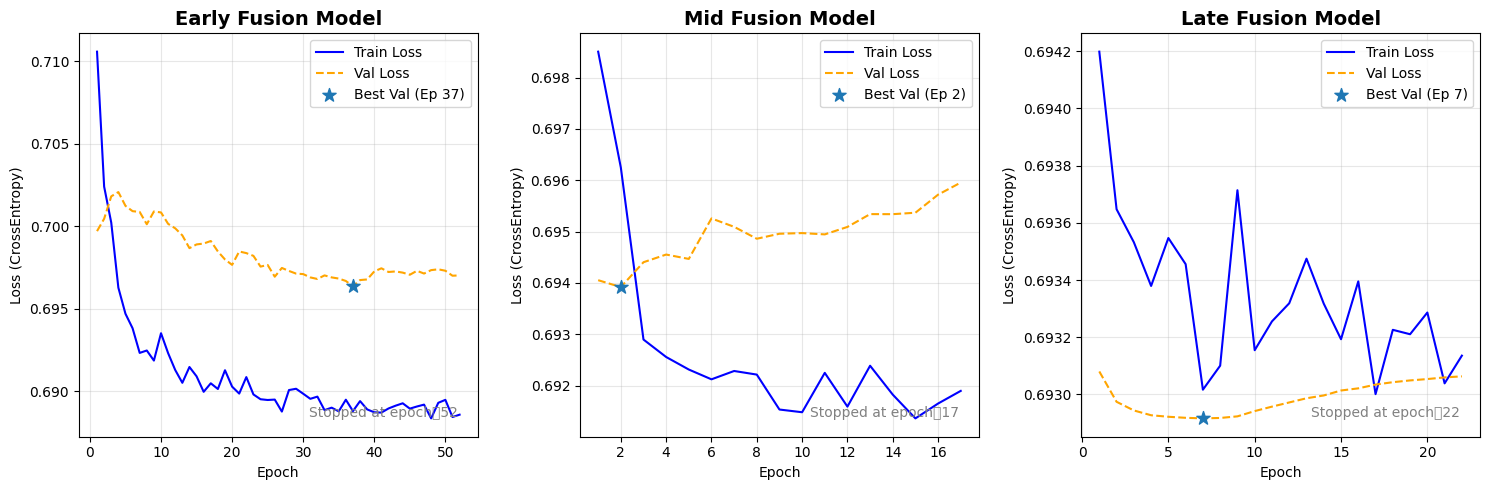

In [102]:
def plot_loss_curves(histories):
    n_models = len(histories)
    cols = n_models
    rows = 1

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5), sharey=False)

    for ax, (name, hist_df) in zip(axes, histories.items()):
        ax.plot(
            hist_df["epoch"], hist_df["train_loss"],
            label="Train Loss", color="blue", linestyle="-"
        )
        ax.plot(
            hist_df["epoch"], hist_df["val_loss"],
            label="Val Loss", color="orange", linestyle="--"
        )

        # Mark the best point
        if hist_df["val_loss"].notna().any():
            best_idx = hist_df["val_loss"].idxmin()
            best_row = hist_df.loc[best_idx]
            best_epoch = int(best_row["epoch"])
            best_val = float(best_row["val_loss"])

            ax.scatter(
                best_epoch, best_val,
                s=100, marker="*", zorder=5,
                label=f"Best Val (Ep {best_epoch})"
            )

        # Plot styling
        ax.set_title(f"{name} Fusion Model", fontsize=14, fontweight="bold")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss (CrossEntropy)")
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Annotate early stopping information
        final_epoch = int(hist_df["epoch"].iloc[-1])
        ax.text(
            0.95, 0.05,
            f"Stopped at epoch: {final_epoch}",
            transform=ax.transAxes,
            ha="right",
            fontsize=10,
            color="gray"
        )

    plt.tight_layout()
    plt.show()

plot_loss_curves(histories)


In [103]:
df_results

,model,split,best_val_loss,threshold,acc,prec,rec,f1,auc,tn,fp,fn,tp
0,Early,val,0.696369,0.05,0.454949,0.454949,1.0,0.625381,0.508323,0,1228,0,1025
1,Mid,val,0.693919,0.05,0.454949,0.454949,1.0,0.625381,0.505364,0,1228,0,1025
2,Late,val,0.692916,0.05,0.454949,0.454949,1.0,0.625381,0.501513,0,1228,0,1025
3,Early,test,0.696369,0.05,0.433304,0.433304,1.0,0.604623,0.523030,0,650,0,497
4,Mid,test,0.693919,0.05,0.433304,0.433304,1.0,0.604623,0.499882,0,650,0,497
5,Late,test,0.692916,0.05,0.433304,0.433304,1.0,0.604623,0.494942,0,650,0,497


In [104]:
@torch.no_grad()
def collect_pred(model, loader, device, split_name, id2code):
    model.eval()
    rows = []
    for X, y, scode_id, date_ns in loader:
        X = X.to(device)
        logits = model(X)
        p_up = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()

        y = y.detach().cpu().numpy().astype(int)
        scode_id = scode_id.detach().cpu().numpy().astype(int)
        date = pd.to_datetime(date_ns.detach().cpu().numpy().astype("int64"))

        for sid, d, yt, p in zip(scode_id, date, y, p_up):
            rows.append({
                "Scode": id2code[int(sid)],
                "Date": d,
                "split": split_name,
                "y_true": int(yt),
                "p_up": float(p),
            })
    pred_df = pd.DataFrame(rows)
    if not pred_df.empty:
        pred_df = pred_df.sort_values(["Scode", "Date"]).reset_index(drop=True)
    return pred_df


In [105]:
pred_all_by_model = {}

for name, model in trained_models.items():
    pred_train = collect_pred(model, train_loader, device, "train", id2code)
    pred_val   = collect_pred(model, val_loader,   device, "val",   id2code)
    pred_test  = collect_pred(model, test_loader,  device, "test",  id2code)
    pred_all_by_model[name] = pd.concat([pred_train, pred_val, pred_test], ignore_index=True)


In [106]:
def plot_fusion_single_company(
    df_all, pred_all, scode,
    train_end, val_end,
    date_col="Date", code_col="Scode", ret_col="Return_1d",
    threshold=None,
    title_prefix="Fusion model P(up)"
):
    # Extract predictions for a single company
    d = pred_all[pred_all["Scode"].astype(str) == str(scode)].copy()
    if d.empty:
        print("No prediction rows for scode:", scode)
        return
    d["Date"] = pd.to_datetime(d["Date"])

    # Extract true returns for the company
    g = df_all[df_all[code_col].astype(str) == str(scode)].copy()
    g[date_col] = pd.to_datetime(g[date_col], errors="coerce")
    g[ret_col] = pd.to_numeric(g[ret_col], errors="coerce")
    g = g.dropna(subset=[date_col, ret_col]).sort_values(date_col)

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Left axis: Return_1d
    ax1.plot(g[date_col], g[ret_col], label=ret_col)
    ax1.set_xlabel("Date")
    ax1.set_ylabel(ret_col)

    # Split lines
    ax1.axvline(pd.Timestamp(train_end), linestyle="--", label="TRAIN_END")
    ax1.axvline(pd.Timestamp(val_end), linestyle="--", label="VAL_END")

    # Right axis: P(up)
    ax2 = ax1.twinx()
    ax2.set_ylabel("P(up)")

    # Plot validation and test predictions
    for split, marker in [("val", "o"), ("test", "s")]:
        dd = d[d["split"] == split]
        if len(dd):
            ax2.plot(
                dd["Date"], dd["p_up"],
                linestyle="None", marker=marker,
                label=f"p_up ({split})", alpha=0.8
            )

    if threshold is not None:
        ax2.axhline(
            float(threshold),
            linestyle=":",
            label=f"thr={threshold:.2f}"
        )

    # Merge legends
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left")

    ax1.set_title(f"{title_prefix} | Scode={scode}")
    plt.tight_layout()
    plt.show()


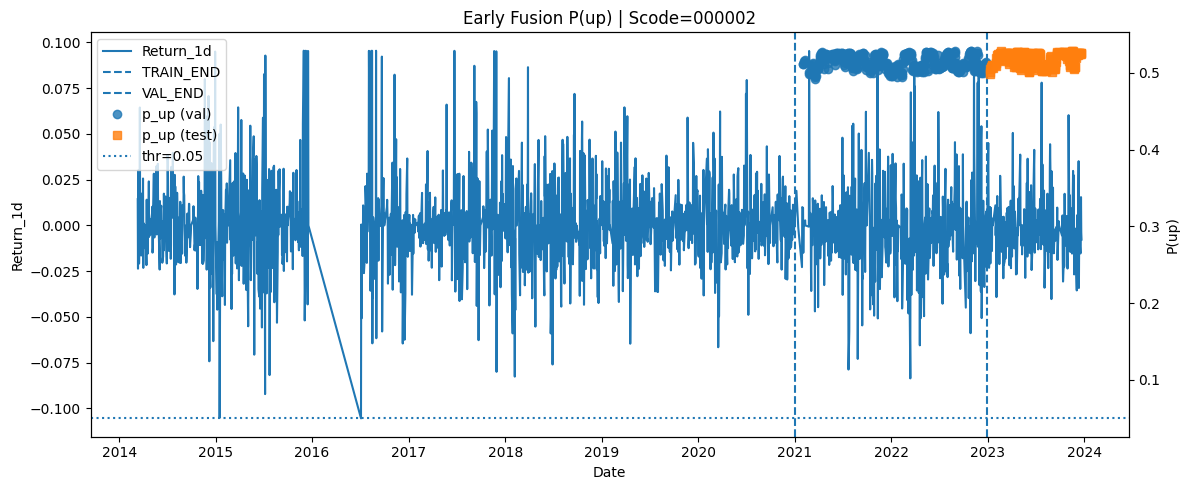

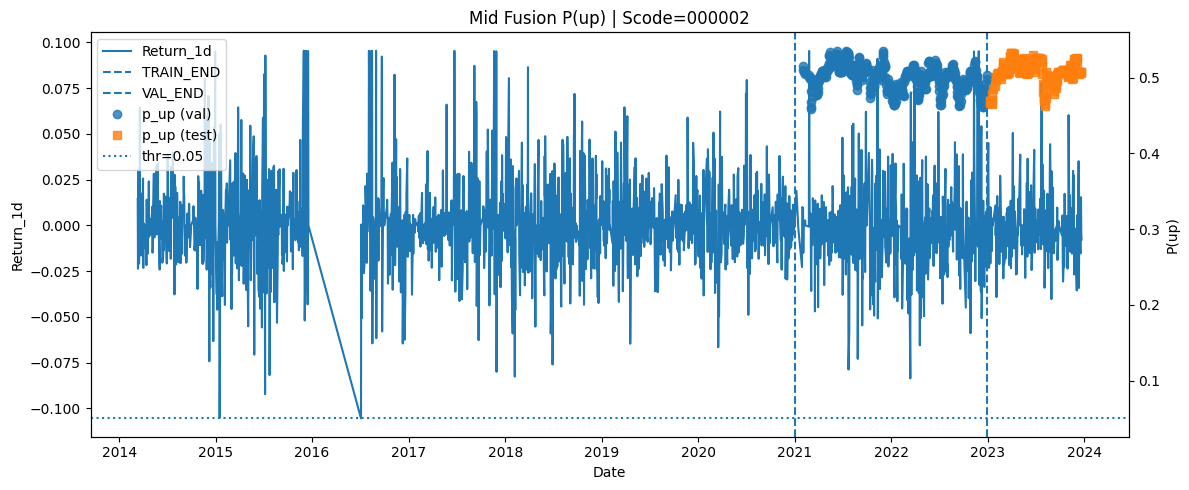

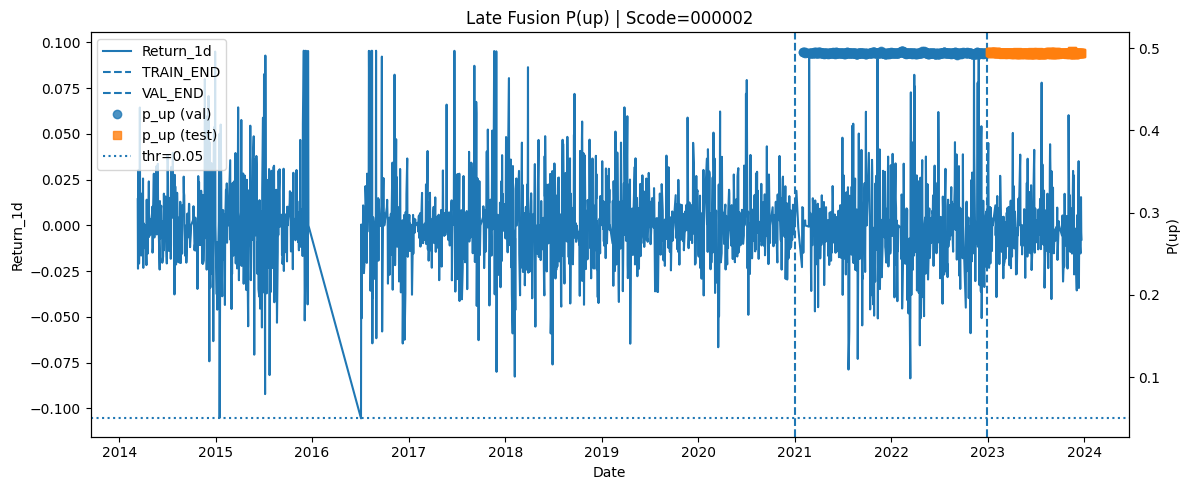

In [107]:
scode = "000002"

for name in ["Early", "Mid", "Late"]:
    pred_all = pred_all_by_model[name]

    thr = df_results.loc[
        (df_results["model"] == name) & (df_results["split"] == "test"),
        "threshold"
    ].iloc[0]

    plot_fusion_single_company(
        df_all=df,
        pred_all=pred_all,
        scode=scode,
        train_end=TRAIN_END,
        val_end=VAL_END,
        date_col="Date", code_col="Scode", ret_col="Return_1d",
        threshold=thr,
        title_prefix=f"{name} Fusion P(up)"
    )


## 5. Sensitivity analysis

In [110]:
def run_models_cfg(
    n_price, n_news,
    train_set, train_loader, val_loader, test_loader,
    epochs=100, lr=1e-4, threshold=0.5, patience=15, device=None,
    dropout=0.5,
    price_hidden_dim=32,
    d_model=32,
    num_heads=4,
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    models = {
        "Early": EarlyFusionPredictor(
            n_price, n_news,
            price_hidden_dim=price_hidden_dim,
            news_out_dim=32,
            fusion_hidden_dim=32,
            dropout=dropout
        ),
        "Mid": MidFusionPredictor(
            n_price=n_price, n_news=n_news,
            price_hidden_dim=price_hidden_dim,
            news_hidden_dim=16,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        ),
        "Late": LateFusionPredictor(
            n_price=n_price, n_news=n_news,
            price_hidden=price_hidden_dim,
            news_hidden=16,
            news_out=16,
            dropout=dropout
        ),
    }

    results = []
    trained_models = {}
    histories = {}

    for name, model in models.items():
        print("\n" + "="*60)
        print(f"Training {name} (select best by min val loss)")
        print("="*60)

        trained_model, hist_df, best_val_loss, val_m, test_m = train_select(
            model_name=name,
            model=model,
            train_set=train_set,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            epochs=epochs,
            lr=lr,
            threshold=threshold,
            patience=patience,
            device=device
        )

        trained_models[name] = trained_model
        histories[name] = hist_df

        results.append({
            "model": name,
            "best_val_loss": best_val_loss,
            "val": val_m,
            "test": test_m
        })

    # Build summary table
    rows = []
    split_order = {"val": 0, "test": 1}

    for r in results:
        for split in ["val", "test"]:
            m = r.get(split, {})
            used_thr = m.get("threshold", threshold)
            cm = m.get("cm", None)
            if isinstance(cm, np.ndarray) and cm.shape == (2, 2):
                tn, fp = int(cm[0, 0]), int(cm[0, 1])
                fn, tp = int(cm[1, 0]), int(cm[1, 1])
            else:
                tn = fp = fn = tp = np.nan

            rows.append({
                "model": r["model"],
                "split": split,
                "split_rank": split_order.get(split, 99),
                "best_val_loss": r["best_val_loss"],
                "threshold": used_thr,
                "acc": m.get("acc", np.nan),
                "prec": m.get("prec", np.nan),
                "rec": m.get("rec", np.nan),
                "f1": m.get("f1", np.nan),
                "auc": m.get("auc", np.nan),
                "tn": tn, "fp": fp, "fn": fn, "tp": tp
            })

    summary_df = pd.DataFrame(rows)
    summary_df = summary_df.sort_values(["split_rank", "f1"], ascending=[True, False]).reset_index(drop=True)
    summary_df = summary_df.drop(columns=["split_rank"])
    test_df = summary_df[summary_df["split"] == "test"].sort_values("f1", ascending=False).reset_index(drop=True)

    return results, summary_df, test_df, trained_models, histories

def build_loaders_for_lag(train_df, val_df, test_df, feature_cols, lag,
                          batch_size=64, shuffle=False):
    train_set, code2id, id2code = make_windows(train_df, feature_cols, lag)
    val_set,   _,      _        = make_windows(val_df,   feature_cols, lag)
    test_set,  _,      _        = make_windows(test_df,  feature_cols, lag)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)
    val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

    return train_set, val_set, test_set, train_loader, val_loader, test_loader, code2id, id2code


def make_param_grid_with_lag():
    grid = []
    for lag in [5, 10, 20]:
        for lr in [1e-4, 3e-4]:
            for dropout in [0.2, 0.5]:
                for price_hidden_dim in [16, 32]:
                    for d_model in [16, 32]:
                        for num_heads in [2, 4]:
                            if d_model % num_heads != 0:
                                continue
                            grid.append({
                                "lag": lag,
                                "batch_size": 64,
                                "lr": lr,
                                "dropout": dropout,
                                "price_hidden_dim": price_hidden_dim,
                                "d_model": d_model,
                                "num_heads": num_heads,
                            })
    return grid

def run_sensitivity_with_lag(
    param_grid,
    n_price, n_news,
    train_df, val_df, test_df,
    feature_cols,
    epochs=30, patience=10, threshold=0.5,
    device=None,
    tag="sens_lag_v1",
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_rows = []

    for i, cfg in enumerate(param_grid, 1):
        lag = int(cfg["lag"])
        bs  = int(cfg.get("batch_size", 64))

        print("\n" + "#" * 90)
        print(f"[{tag}] Run {i}/{len(param_grid)} | lag={lag} bs={bs} | cfg={cfg}")
        print("#" * 90)

        # Rebuild windows and data loaders
        train_set, val_set, test_set, train_loader, val_loader, test_loader, code2id, id2code = \
            build_loaders_for_lag(
                train_df, val_df, test_df,
                feature_cols, lag,
                batch_size=bs, shuffle=False
            )

        print(
            f"Windows: train={len(train_set)} "
            f"val={len(val_set)} test={len(test_set)} | "
            f"#codes={len(code2id)}"
        )

        # Skip if any dataset is empty
        if len(train_set) == 0 or len(val_set) == 0 or len(test_set) == 0:
            print("Skip: empty windows for this lag/config.")
            continue

        # Training
        _, df_results, _, trained_models, histories = run_models_cfg(
            n_price=n_price, n_news=n_news,
            train_set=train_set,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            epochs=epochs,
            lr=float(cfg["lr"]),
            threshold=threshold,
            patience=patience,
            device=device,
            dropout=float(cfg["dropout"]),
            price_hidden_dim=int(cfg["price_hidden_dim"]),
            d_model=int(cfg["d_model"]),
            num_heads=int(cfg["num_heads"]),
        )

        # Expand df_results and attach dataset size information
        for _, r in df_results.iterrows():
            row = r.to_dict()
            row["tag"] = tag

            # Configuration parameters
            for k, v in cfg.items():
                row[f"cfg_{k}"] = v

            # Dataset size information
            row["n_train_win"] = len(train_set)
            row["n_val_win"]   = len(val_set)
            row["n_test_win"]  = len(test_set)
            row["n_codes"]     = len(code2id)

            all_rows.append(row)

    return pd.DataFrame(all_rows)
    

In [111]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

param_grid = make_param_grid_with_lag()

sens_df = run_sensitivity_with_lag(
    param_grid=param_grid,
    n_price=n_price, n_news=n_news,
    train_df=train_df, val_df=val_df, test_df=test_df,
    feature_cols=FEATURE_COLS,
    epochs=30, patience=10, threshold=0.5,
    device=device,
    tag="fusion_sens_with_lag"
)

sens_df.head()

best_test = (
    sens_df[sens_df["split"] == "test"]
    .sort_values(["auc", "f1"], ascending=False)
    .head(15)
)
best_test

mid_test = sens_df[(sens_df["model"]=="Mid") & (sens_df["split"]=="test")].copy()
mid_test.groupby("cfg_lag")[["auc","f1","acc"]].mean().sort_values("auc", ascending=False)



##########################################################################################
[fusion_sens_with_lag] Run 1/96 | lag=5 bs=64 | cfg={'lag': 5, 'batch_size': 64, 'lr': 0.0001, 'dropout': 0.2, 'price_hidden_dim': 16, 'd_model': 16, 'num_heads': 2}
##########################################################################################
Windows: train=8038 val=2253 test=1147 | #codes=5

Training Early (select best by min val loss)
[Early] Epoch 01 | Train 0.6974 | Val 0.6967 | BestVal 0.6967
[Early] Epoch 02 | Train 0.6950 | Val 0.6971 | BestVal 0.6967
[Early] Epoch 03 | Train 0.6938 | Val 0.6973 | BestVal 0.6967
[Early] Epoch 04 | Train 0.6923 | Val 0.6982 | BestVal 0.6967
[Early] Epoch 05 | Train 0.6913 | Val 0.6983 | BestVal 0.6967
[Early] Epoch 06 | Train 0.6908 | Val 0.6983 | BestVal 0.6967
[Early] Epoch 07 | Train 0.6918 | Val 0.6985 | BestVal 0.6967
[Early] Epoch 08 | Train 0.6910 | Val 0.6990 | BestVal 0.6967
[Early] Epoch 09 | Train 0.6907 | Val 0.6990 | BestVal 0.69

,auc,f1,acc
cfg_lag,,,
20,0.502090,0.603041,0.432165
5,0.496191,0.604623,0.433304
10,0.493769,0.597500,0.426025


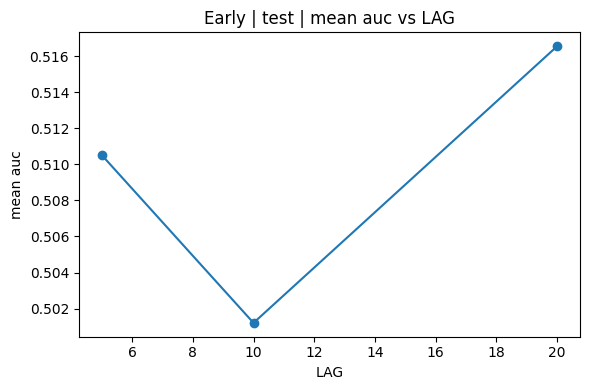

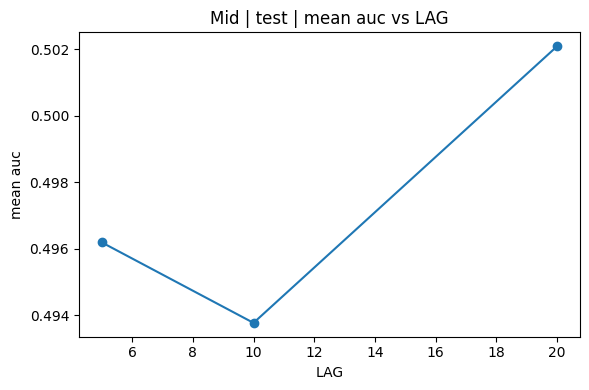

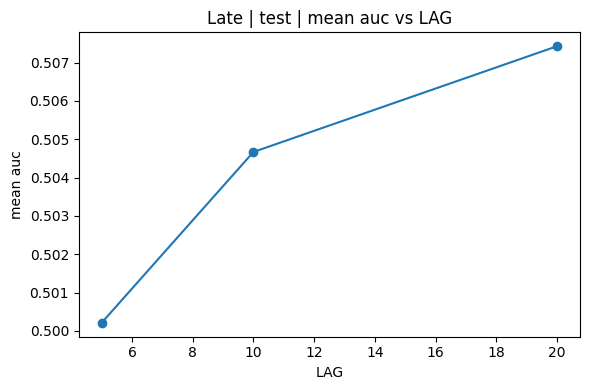

In [112]:
def plot_lag_sensitivity(sens_df, model="Mid", split="test", metric="auc"):
    d = sens_df[(sens_df["model"]==model) & (sens_df["split"]==split)].copy()
    if d.empty:
        print("No rows")
        return
    grp = d.groupby("cfg_lag")[metric].mean().reset_index()

    plt.figure(figsize=(6,4))
    plt.plot(grp["cfg_lag"], grp[metric], marker="o")
    plt.xlabel("LAG")
    plt.ylabel(f"mean {metric}")
    plt.title(f"{model} | {split} | mean {metric} vs LAG")
    plt.tight_layout()
    plt.show()

plot_lag_sensitivity(sens_df, model="Early", split="test", metric="auc")
plot_lag_sensitivity(sens_df, model="Mid",   split="test", metric="auc")
plot_lag_sensitivity(sens_df, model="Late",  split="test", metric="auc")


In [113]:
def topk_by_f1(sens_df, split="test", k=15):
    d = sens_df[sens_df["split"] == split].copy()
    if d.empty:
        print("sens_df has no rows for split=", split)
        return d

    # 以 F1 为主，AUC 为辅
    d = d.sort_values(["f1", "auc"], ascending=False).head(k)
    keep_cols = [c for c in d.columns if c in [
        "model","split","f1","auc","acc","prec","rec",
        "best_val_loss","threshold",
        "cfg_lag","cfg_lr","cfg_dropout","cfg_price_hidden_dim","cfg_d_model","cfg_num_heads",
        "n_train_win","n_val_win","n_test_win","n_codes",
        "tag"
    ]]
    return d[keep_cols]

best_test_f1 = topk_by_f1(sens_df, split="test", k=15)
best_test_f1

def summarize_param_sensitivity(
    sens_df,
    model="Mid",
    split="test",
    metric="f1",
    param="cfg_lag",
):
    d = sens_df[(sens_df["model"]==model) & (sens_df["split"]==split)].copy()
    if d.empty:
        print("No rows for", model, split)
        return None

    out = (
        d.groupby(param)[metric]
         .agg(["mean","std","count"])
         .sort_values("mean", ascending=False)
    )
    return out


In [114]:
params = ["cfg_lag", "cfg_lr", "cfg_dropout", "cfg_price_hidden_dim", "cfg_d_model", "cfg_num_heads"]

for m in ["Early","Mid","Late"]:
    print("\n" + "="*90)
    print(f"{m} | test | F1 sensitivity (group means)")
    for p in params:
        print("\n-- grouped by", p)
        display(summarize_param_sensitivity(sens_df, model=m, split="test", metric="f1", param=p))



Early | test | F1 sensitivity (group means)

-- grouped by cfg_lag


,mean,std,count
cfg_lag,,,
5,0.604623,0.000000,32
20,0.603257,0.000000,32
10,0.597512,0.000066,32



-- grouped by cfg_lr


,mean,std,count
cfg_lr,,,
0.0003,0.601801,0.003109,48
0.0001,0.601793,0.003119,48



-- grouped by cfg_dropout


,mean,std,count
cfg_dropout,,,
0.2,0.601801,0.003109,48
0.5,0.601793,0.003119,48



-- grouped by cfg_price_hidden_dim


,mean,std,count
cfg_price_hidden_dim,,,
32,0.601801,0.003109,48
16,0.601793,0.003119,48



-- grouped by cfg_d_model


,mean,std,count
cfg_d_model,,,
32,0.601801,0.003109,48
16,0.601793,0.003119,48



-- grouped by cfg_num_heads


,mean,std,count
cfg_num_heads,,,
4,0.601801,0.003109,48
2,0.601793,0.003119,48



Mid | test | F1 sensitivity (group means)

-- grouped by cfg_lag


,mean,std,count
cfg_lag,,,
5,0.604623,0.000000,32
20,0.603041,0.000886,32
10,0.597500,0.000000,32



-- grouped by cfg_lr


,mean,std,count
cfg_lr,,,
0.0003,0.601793,0.003119,48
0.0001,0.601649,0.003135,48



-- grouped by cfg_dropout


,mean,std,count
cfg_dropout,,,
0.5,0.601742,0.003115,48
0.2,0.601701,0.003141,48



-- grouped by cfg_price_hidden_dim


,mean,std,count
cfg_price_hidden_dim,,,
16,0.601742,0.003115,48
32,0.601701,0.003141,48



-- grouped by cfg_d_model


,mean,std,count
cfg_d_model,,,
16,0.601793,0.003119,48
32,0.601649,0.003135,48



-- grouped by cfg_num_heads


,mean,std,count
cfg_num_heads,,,
2,0.601793,0.003119,48
4,0.601649,0.003135,48



Late | test | F1 sensitivity (group means)

-- grouped by cfg_lag


,mean,std,count
cfg_lag,,,
5,0.604623,0.0,32
20,0.603257,0.0,32
10,0.597500,0.0,32



-- grouped by cfg_lr


,mean,std,count
cfg_lr,,,
0.0001,0.601793,0.003119,48
0.0003,0.601793,0.003119,48



-- grouped by cfg_dropout


,mean,std,count
cfg_dropout,,,
0.2,0.601793,0.003119,48
0.5,0.601793,0.003119,48



-- grouped by cfg_price_hidden_dim


,mean,std,count
cfg_price_hidden_dim,,,
16,0.601793,0.003119,48
32,0.601793,0.003119,48



-- grouped by cfg_d_model


,mean,std,count
cfg_d_model,,,
16,0.601793,0.003119,48
32,0.601793,0.003119,48



-- grouped by cfg_num_heads


,mean,std,count
cfg_num_heads,,,
2,0.601793,0.003119,48
4,0.601793,0.003119,48
